# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


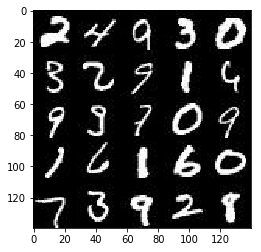

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

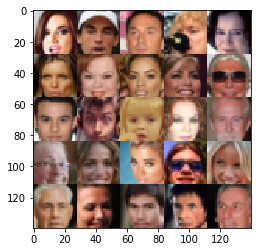

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(x, 64, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d(x, 256, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 4 * 4 * 512)
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding="same")
        out = tf.tanh(x)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    dis, gen, f1 = [], [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                train_loss_g = g_loss.eval({input_z: batch_z})
                dis.append(train_loss_d)
                gen.append(train_loss_g)
                val = (train_loss_d + train_loss_g) / 2
                f1.append(val)
                if steps % 20 == 0:

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 200 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
    return dis, gen, f1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 20... Discriminator Loss: 0.4088... Generator Loss: 3.6732
Epoch 1/2... Batch 40... Discriminator Loss: 1.4146... Generator Loss: 0.5335
Epoch 1/2... Batch 60... Discriminator Loss: 0.5329... Generator Loss: 2.8029
Epoch 1/2... Batch 80... Discriminator Loss: 0.6382... Generator Loss: 1.7478
Epoch 1/2... Batch 100... Discriminator Loss: 1.3626... Generator Loss: 2.7623
Epoch 1/2... Batch 120... Discriminator Loss: 0.9162... Generator Loss: 2.6621
Epoch 1/2... Batch 140... Discriminator Loss: 0.9787... Generator Loss: 1.0723
Epoch 1/2... Batch 160... Discriminator Loss: 1.5727... Generator Loss: 0.6302
Epoch 1/2... Batch 180... Discriminator Loss: 1.9762... Generator Loss: 0.3077
Epoch 1/2... Batch 200... Discriminator Loss: 1.2224... Generator Loss: 0.7531


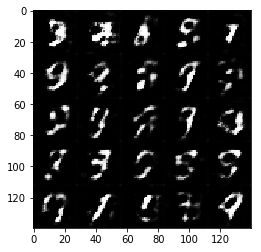

Epoch 1/2... Batch 220... Discriminator Loss: 1.9871... Generator Loss: 2.5033
Epoch 1/2... Batch 240... Discriminator Loss: 1.2163... Generator Loss: 1.4583
Epoch 1/2... Batch 260... Discriminator Loss: 1.2875... Generator Loss: 0.6234
Epoch 1/2... Batch 280... Discriminator Loss: 1.1800... Generator Loss: 1.4528
Epoch 1/2... Batch 300... Discriminator Loss: 1.1967... Generator Loss: 1.0853
Epoch 1/2... Batch 320... Discriminator Loss: 1.2344... Generator Loss: 2.5426
Epoch 1/2... Batch 340... Discriminator Loss: 1.0664... Generator Loss: 0.9040
Epoch 1/2... Batch 360... Discriminator Loss: 1.0691... Generator Loss: 0.8945
Epoch 1/2... Batch 380... Discriminator Loss: 1.2248... Generator Loss: 1.9460
Epoch 1/2... Batch 400... Discriminator Loss: 1.7848... Generator Loss: 0.3366


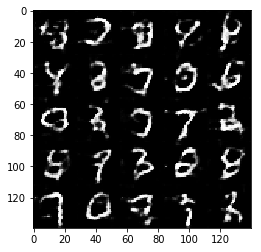

Epoch 1/2... Batch 420... Discriminator Loss: 1.2585... Generator Loss: 0.6289
Epoch 1/2... Batch 440... Discriminator Loss: 1.1785... Generator Loss: 0.7980
Epoch 1/2... Batch 460... Discriminator Loss: 1.1255... Generator Loss: 1.7741
Epoch 2/2... Batch 20... Discriminator Loss: 1.2486... Generator Loss: 0.6596
Epoch 2/2... Batch 40... Discriminator Loss: 1.2548... Generator Loss: 2.0987
Epoch 2/2... Batch 60... Discriminator Loss: 0.9988... Generator Loss: 1.2637
Epoch 2/2... Batch 80... Discriminator Loss: 1.2754... Generator Loss: 0.6022
Epoch 2/2... Batch 100... Discriminator Loss: 0.9955... Generator Loss: 1.4693
Epoch 2/2... Batch 120... Discriminator Loss: 1.0020... Generator Loss: 1.0204
Epoch 2/2... Batch 140... Discriminator Loss: 1.0210... Generator Loss: 1.2116
Epoch 2/2... Batch 160... Discriminator Loss: 1.1252... Generator Loss: 0.9684
Epoch 2/2... Batch 180... Discriminator Loss: 0.9825... Generator Loss: 1.6081
Epoch 2/2... Batch 200... Discriminator Loss: 1.2079... 

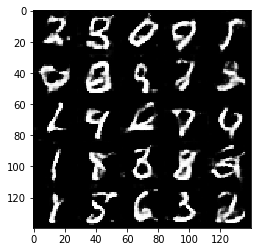

Epoch 2/2... Batch 220... Discriminator Loss: 1.1219... Generator Loss: 0.8688
Epoch 2/2... Batch 240... Discriminator Loss: 1.3001... Generator Loss: 1.8684
Epoch 2/2... Batch 260... Discriminator Loss: 1.0953... Generator Loss: 1.4331
Epoch 2/2... Batch 280... Discriminator Loss: 1.0569... Generator Loss: 1.1223
Epoch 2/2... Batch 300... Discriminator Loss: 1.0852... Generator Loss: 1.9453
Epoch 2/2... Batch 320... Discriminator Loss: 1.3421... Generator Loss: 3.8150
Epoch 2/2... Batch 340... Discriminator Loss: 2.0551... Generator Loss: 0.2603
Epoch 2/2... Batch 360... Discriminator Loss: 1.1081... Generator Loss: 1.4212
Epoch 2/2... Batch 380... Discriminator Loss: 1.0841... Generator Loss: 2.1134
Epoch 2/2... Batch 400... Discriminator Loss: 0.9634... Generator Loss: 0.9411


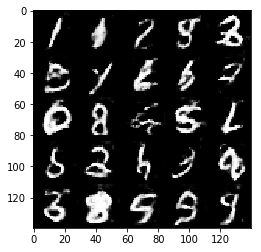

Epoch 2/2... Batch 420... Discriminator Loss: 1.5805... Generator Loss: 0.4482
Epoch 2/2... Batch 440... Discriminator Loss: 0.7901... Generator Loss: 1.4396
Epoch 2/2... Batch 460... Discriminator Loss: 1.0813... Generator Loss: 1.7337


In [15]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [21]:
files = glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))
len(files)

202599

Epoch 1/10... Batch 20... Discriminator Loss: 1.0641... Generator Loss: 1.3255
Epoch 1/10... Batch 40... Discriminator Loss: 0.5094... Generator Loss: 5.5799
Epoch 1/10... Batch 60... Discriminator Loss: 1.7955... Generator Loss: 0.5520
Epoch 1/10... Batch 80... Discriminator Loss: 1.9459... Generator Loss: 6.0014
Epoch 1/10... Batch 100... Discriminator Loss: 1.0503... Generator Loss: 1.4179
Epoch 1/10... Batch 120... Discriminator Loss: 1.3399... Generator Loss: 2.8896
Epoch 1/10... Batch 140... Discriminator Loss: 1.3617... Generator Loss: 0.6285
Epoch 1/10... Batch 160... Discriminator Loss: 1.4623... Generator Loss: 0.5419
Epoch 1/10... Batch 180... Discriminator Loss: 1.3217... Generator Loss: 1.0902
Epoch 1/10... Batch 200... Discriminator Loss: 1.4320... Generator Loss: 0.7227


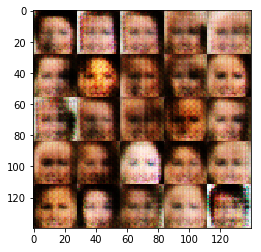

Epoch 1/10... Batch 220... Discriminator Loss: 1.2208... Generator Loss: 0.7378
Epoch 1/10... Batch 240... Discriminator Loss: 1.2810... Generator Loss: 0.7375
Epoch 1/10... Batch 260... Discriminator Loss: 1.1569... Generator Loss: 0.6817
Epoch 1/10... Batch 280... Discriminator Loss: 1.1108... Generator Loss: 1.0338
Epoch 1/10... Batch 300... Discriminator Loss: 1.2821... Generator Loss: 1.0960
Epoch 1/10... Batch 320... Discriminator Loss: 1.2196... Generator Loss: 0.6904
Epoch 1/10... Batch 340... Discriminator Loss: 1.4690... Generator Loss: 0.4911
Epoch 1/10... Batch 360... Discriminator Loss: 1.7334... Generator Loss: 0.3480
Epoch 1/10... Batch 380... Discriminator Loss: 1.1710... Generator Loss: 0.9944
Epoch 1/10... Batch 400... Discriminator Loss: 1.5139... Generator Loss: 0.4539


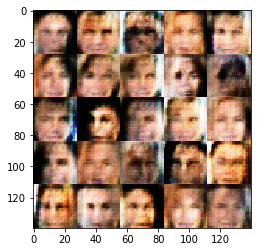

Epoch 1/10... Batch 420... Discriminator Loss: 1.1204... Generator Loss: 1.0620
Epoch 1/10... Batch 440... Discriminator Loss: 1.3379... Generator Loss: 0.6840
Epoch 1/10... Batch 460... Discriminator Loss: 1.2278... Generator Loss: 0.8057
Epoch 1/10... Batch 480... Discriminator Loss: 1.3350... Generator Loss: 1.1479
Epoch 1/10... Batch 500... Discriminator Loss: 1.3262... Generator Loss: 0.9499
Epoch 1/10... Batch 520... Discriminator Loss: 1.4122... Generator Loss: 0.5536
Epoch 1/10... Batch 540... Discriminator Loss: 1.2920... Generator Loss: 0.9586
Epoch 1/10... Batch 560... Discriminator Loss: 1.4318... Generator Loss: 1.5533
Epoch 1/10... Batch 580... Discriminator Loss: 1.1790... Generator Loss: 0.8226
Epoch 1/10... Batch 600... Discriminator Loss: 1.2983... Generator Loss: 0.7018


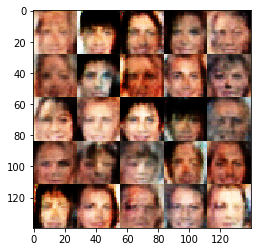

Epoch 1/10... Batch 620... Discriminator Loss: 1.2884... Generator Loss: 1.3011
Epoch 1/10... Batch 640... Discriminator Loss: 1.3732... Generator Loss: 1.2052
Epoch 1/10... Batch 660... Discriminator Loss: 1.3655... Generator Loss: 0.7318
Epoch 1/10... Batch 680... Discriminator Loss: 1.2864... Generator Loss: 0.9096
Epoch 1/10... Batch 700... Discriminator Loss: 1.4524... Generator Loss: 0.6618
Epoch 1/10... Batch 720... Discriminator Loss: 1.4308... Generator Loss: 0.5896
Epoch 1/10... Batch 740... Discriminator Loss: 1.4262... Generator Loss: 0.5006
Epoch 1/10... Batch 760... Discriminator Loss: 1.5029... Generator Loss: 0.4881
Epoch 1/10... Batch 780... Discriminator Loss: 0.8603... Generator Loss: 1.2818
Epoch 1/10... Batch 800... Discriminator Loss: 1.1727... Generator Loss: 0.9519


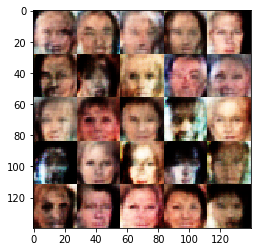

Epoch 1/10... Batch 820... Discriminator Loss: 1.0954... Generator Loss: 1.9131
Epoch 1/10... Batch 840... Discriminator Loss: 1.2601... Generator Loss: 1.5357
Epoch 1/10... Batch 860... Discriminator Loss: 1.5305... Generator Loss: 0.4577
Epoch 1/10... Batch 880... Discriminator Loss: 1.2584... Generator Loss: 0.6201
Epoch 1/10... Batch 900... Discriminator Loss: 1.2174... Generator Loss: 0.9580
Epoch 1/10... Batch 920... Discriminator Loss: 1.3964... Generator Loss: 1.3922
Epoch 1/10... Batch 940... Discriminator Loss: 1.5279... Generator Loss: 0.4465
Epoch 1/10... Batch 960... Discriminator Loss: 1.1969... Generator Loss: 1.3479
Epoch 1/10... Batch 980... Discriminator Loss: 1.0119... Generator Loss: 1.4647
Epoch 1/10... Batch 1000... Discriminator Loss: 1.5743... Generator Loss: 2.1341


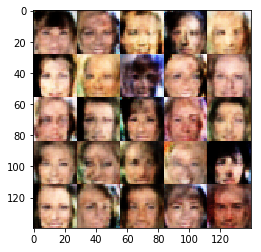

Epoch 1/10... Batch 1020... Discriminator Loss: 0.9843... Generator Loss: 1.0601
Epoch 1/10... Batch 1040... Discriminator Loss: 1.2592... Generator Loss: 0.6046
Epoch 1/10... Batch 1060... Discriminator Loss: 1.2128... Generator Loss: 0.6449
Epoch 1/10... Batch 1080... Discriminator Loss: 1.0638... Generator Loss: 0.9184
Epoch 1/10... Batch 1100... Discriminator Loss: 1.4422... Generator Loss: 1.4323
Epoch 1/10... Batch 1120... Discriminator Loss: 1.0940... Generator Loss: 0.9955
Epoch 1/10... Batch 1140... Discriminator Loss: 1.1340... Generator Loss: 1.1135
Epoch 1/10... Batch 1160... Discriminator Loss: 1.1200... Generator Loss: 0.9148
Epoch 1/10... Batch 1180... Discriminator Loss: 1.5684... Generator Loss: 0.4036
Epoch 1/10... Batch 1200... Discriminator Loss: 1.3908... Generator Loss: 1.4525


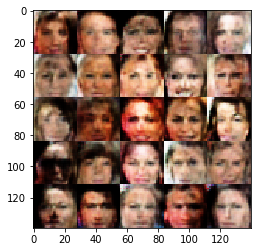

Epoch 1/10... Batch 1220... Discriminator Loss: 1.7949... Generator Loss: 2.3569
Epoch 1/10... Batch 1240... Discriminator Loss: 1.0252... Generator Loss: 1.3279
Epoch 1/10... Batch 1260... Discriminator Loss: 1.1283... Generator Loss: 0.7008
Epoch 1/10... Batch 1280... Discriminator Loss: 1.2513... Generator Loss: 0.5816
Epoch 1/10... Batch 1300... Discriminator Loss: 1.1981... Generator Loss: 1.1667
Epoch 1/10... Batch 1320... Discriminator Loss: 1.1818... Generator Loss: 1.9641
Epoch 1/10... Batch 1340... Discriminator Loss: 0.9430... Generator Loss: 1.4504
Epoch 1/10... Batch 1360... Discriminator Loss: 1.1037... Generator Loss: 1.1914
Epoch 1/10... Batch 1380... Discriminator Loss: 0.9783... Generator Loss: 1.0090
Epoch 1/10... Batch 1400... Discriminator Loss: 1.1397... Generator Loss: 0.7983


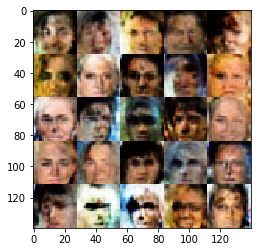

Epoch 1/10... Batch 1420... Discriminator Loss: 1.0444... Generator Loss: 1.4839
Epoch 1/10... Batch 1440... Discriminator Loss: 1.1111... Generator Loss: 0.8966
Epoch 1/10... Batch 1460... Discriminator Loss: 1.1306... Generator Loss: 1.7398
Epoch 1/10... Batch 1480... Discriminator Loss: 1.0993... Generator Loss: 1.3368
Epoch 1/10... Batch 1500... Discriminator Loss: 1.2916... Generator Loss: 0.6900
Epoch 1/10... Batch 1520... Discriminator Loss: 1.2375... Generator Loss: 0.6479
Epoch 1/10... Batch 1540... Discriminator Loss: 1.5533... Generator Loss: 1.6899
Epoch 1/10... Batch 1560... Discriminator Loss: 1.2840... Generator Loss: 0.5606
Epoch 1/10... Batch 1580... Discriminator Loss: 1.0856... Generator Loss: 0.8072
Epoch 2/10... Batch 20... Discriminator Loss: 0.8777... Generator Loss: 1.2408
Epoch 2/10... Batch 40... Discriminator Loss: 0.9506... Generator Loss: 1.1943
Epoch 2/10... Batch 60... Discriminator Loss: 0.9660... Generator Loss: 1.3889
Epoch 2/10... Batch 80... Discrimi

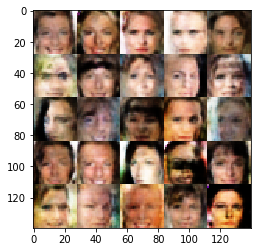

Epoch 2/10... Batch 220... Discriminator Loss: 1.5309... Generator Loss: 0.5304
Epoch 2/10... Batch 240... Discriminator Loss: 1.2783... Generator Loss: 0.7405
Epoch 2/10... Batch 260... Discriminator Loss: 0.9040... Generator Loss: 1.1180
Epoch 2/10... Batch 280... Discriminator Loss: 1.0653... Generator Loss: 1.4744
Epoch 2/10... Batch 300... Discriminator Loss: 1.0476... Generator Loss: 0.8596
Epoch 2/10... Batch 320... Discriminator Loss: 1.5723... Generator Loss: 0.4019
Epoch 2/10... Batch 340... Discriminator Loss: 0.8539... Generator Loss: 1.3067
Epoch 2/10... Batch 360... Discriminator Loss: 0.9389... Generator Loss: 1.1271
Epoch 2/10... Batch 380... Discriminator Loss: 1.1022... Generator Loss: 1.9471
Epoch 2/10... Batch 400... Discriminator Loss: 1.1117... Generator Loss: 2.0478


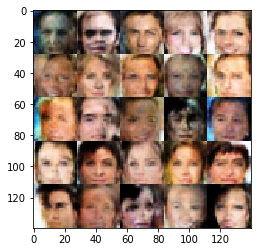

Epoch 2/10... Batch 420... Discriminator Loss: 0.8609... Generator Loss: 1.0363
Epoch 2/10... Batch 440... Discriminator Loss: 1.3461... Generator Loss: 2.0549
Epoch 2/10... Batch 460... Discriminator Loss: 1.8868... Generator Loss: 0.2703
Epoch 2/10... Batch 480... Discriminator Loss: 1.7731... Generator Loss: 0.3075
Epoch 2/10... Batch 500... Discriminator Loss: 0.7949... Generator Loss: 2.3934
Epoch 2/10... Batch 520... Discriminator Loss: 0.9947... Generator Loss: 0.8706
Epoch 2/10... Batch 540... Discriminator Loss: 1.0949... Generator Loss: 1.6606
Epoch 2/10... Batch 560... Discriminator Loss: 1.2440... Generator Loss: 2.6789
Epoch 2/10... Batch 580... Discriminator Loss: 0.8237... Generator Loss: 1.5820
Epoch 2/10... Batch 600... Discriminator Loss: 1.4542... Generator Loss: 0.4524


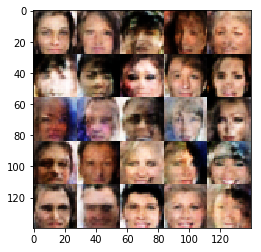

Epoch 2/10... Batch 620... Discriminator Loss: 1.2321... Generator Loss: 0.5816
Epoch 2/10... Batch 640... Discriminator Loss: 0.8692... Generator Loss: 2.0956
Epoch 2/10... Batch 660... Discriminator Loss: 1.3428... Generator Loss: 1.0990
Epoch 2/10... Batch 680... Discriminator Loss: 1.2896... Generator Loss: 0.5916
Epoch 2/10... Batch 700... Discriminator Loss: 0.5942... Generator Loss: 2.4999
Epoch 2/10... Batch 720... Discriminator Loss: 1.0398... Generator Loss: 2.0176
Epoch 2/10... Batch 740... Discriminator Loss: 0.9458... Generator Loss: 0.9530
Epoch 2/10... Batch 760... Discriminator Loss: 1.0509... Generator Loss: 0.8371
Epoch 2/10... Batch 780... Discriminator Loss: 1.5791... Generator Loss: 1.8958
Epoch 2/10... Batch 800... Discriminator Loss: 1.3152... Generator Loss: 0.5782


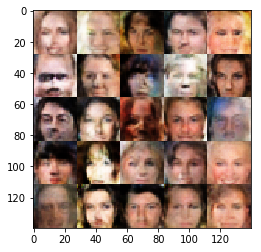

Epoch 2/10... Batch 820... Discriminator Loss: 1.2033... Generator Loss: 0.6393
Epoch 2/10... Batch 840... Discriminator Loss: 1.3137... Generator Loss: 2.6501
Epoch 2/10... Batch 860... Discriminator Loss: 1.5639... Generator Loss: 2.3781
Epoch 2/10... Batch 880... Discriminator Loss: 1.7189... Generator Loss: 2.2498
Epoch 2/10... Batch 900... Discriminator Loss: 0.9631... Generator Loss: 1.6429
Epoch 2/10... Batch 920... Discriminator Loss: 1.5326... Generator Loss: 2.6576
Epoch 2/10... Batch 940... Discriminator Loss: 1.1940... Generator Loss: 0.6436
Epoch 2/10... Batch 960... Discriminator Loss: 0.7102... Generator Loss: 1.9621
Epoch 2/10... Batch 980... Discriminator Loss: 1.1747... Generator Loss: 1.2282
Epoch 2/10... Batch 1000... Discriminator Loss: 1.5215... Generator Loss: 2.3469


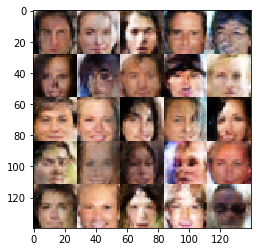

Epoch 2/10... Batch 1020... Discriminator Loss: 0.8231... Generator Loss: 1.2949
Epoch 2/10... Batch 1040... Discriminator Loss: 0.8910... Generator Loss: 2.1414
Epoch 2/10... Batch 1060... Discriminator Loss: 0.6232... Generator Loss: 2.0718
Epoch 2/10... Batch 1080... Discriminator Loss: 0.7786... Generator Loss: 2.5559
Epoch 2/10... Batch 1100... Discriminator Loss: 0.8651... Generator Loss: 2.3541
Epoch 2/10... Batch 1120... Discriminator Loss: 0.9484... Generator Loss: 0.9400
Epoch 2/10... Batch 1140... Discriminator Loss: 0.6722... Generator Loss: 2.8799
Epoch 2/10... Batch 1160... Discriminator Loss: 1.1356... Generator Loss: 0.9165
Epoch 2/10... Batch 1180... Discriminator Loss: 1.0573... Generator Loss: 1.8912
Epoch 2/10... Batch 1200... Discriminator Loss: 0.7663... Generator Loss: 1.3082


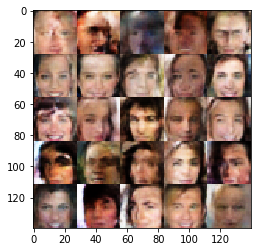

Epoch 2/10... Batch 1220... Discriminator Loss: 0.6829... Generator Loss: 2.7391
Epoch 2/10... Batch 1240... Discriminator Loss: 0.8131... Generator Loss: 1.2100
Epoch 2/10... Batch 1260... Discriminator Loss: 2.6030... Generator Loss: 3.0862
Epoch 2/10... Batch 1280... Discriminator Loss: 1.1163... Generator Loss: 1.1822
Epoch 2/10... Batch 1300... Discriminator Loss: 1.1651... Generator Loss: 2.2604
Epoch 2/10... Batch 1320... Discriminator Loss: 1.5202... Generator Loss: 2.6271
Epoch 2/10... Batch 1340... Discriminator Loss: 1.1277... Generator Loss: 0.7654
Epoch 2/10... Batch 1360... Discriminator Loss: 0.7657... Generator Loss: 1.3438
Epoch 2/10... Batch 1380... Discriminator Loss: 0.9360... Generator Loss: 1.4774
Epoch 2/10... Batch 1400... Discriminator Loss: 0.7714... Generator Loss: 1.4020


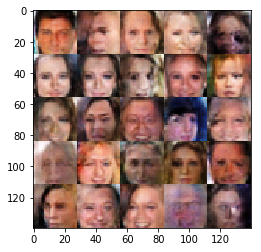

Epoch 2/10... Batch 1420... Discriminator Loss: 1.1859... Generator Loss: 0.6985
Epoch 2/10... Batch 1440... Discriminator Loss: 0.8459... Generator Loss: 1.1777
Epoch 2/10... Batch 1460... Discriminator Loss: 1.4856... Generator Loss: 2.3699
Epoch 2/10... Batch 1480... Discriminator Loss: 1.2923... Generator Loss: 0.6081
Epoch 2/10... Batch 1500... Discriminator Loss: 0.7202... Generator Loss: 1.7391
Epoch 2/10... Batch 1520... Discriminator Loss: 0.8075... Generator Loss: 1.4493
Epoch 2/10... Batch 1540... Discriminator Loss: 0.8126... Generator Loss: 1.3395
Epoch 2/10... Batch 1560... Discriminator Loss: 0.6961... Generator Loss: 2.2564
Epoch 2/10... Batch 1580... Discriminator Loss: 1.2692... Generator Loss: 1.9561
Epoch 3/10... Batch 20... Discriminator Loss: 0.6785... Generator Loss: 2.2020
Epoch 3/10... Batch 40... Discriminator Loss: 0.9200... Generator Loss: 1.0050
Epoch 3/10... Batch 60... Discriminator Loss: 1.0950... Generator Loss: 1.1672
Epoch 3/10... Batch 80... Discrimi

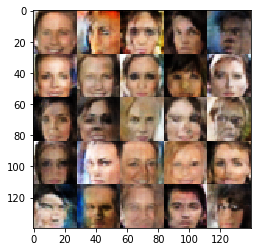

Epoch 3/10... Batch 220... Discriminator Loss: 1.1505... Generator Loss: 1.8618
Epoch 3/10... Batch 240... Discriminator Loss: 0.6337... Generator Loss: 1.6645
Epoch 3/10... Batch 260... Discriminator Loss: 0.9569... Generator Loss: 0.9310
Epoch 3/10... Batch 280... Discriminator Loss: 0.9255... Generator Loss: 1.2457
Epoch 3/10... Batch 300... Discriminator Loss: 1.1558... Generator Loss: 0.7370
Epoch 3/10... Batch 320... Discriminator Loss: 1.4710... Generator Loss: 0.5208
Epoch 3/10... Batch 340... Discriminator Loss: 1.0604... Generator Loss: 2.4192
Epoch 3/10... Batch 360... Discriminator Loss: 0.7248... Generator Loss: 1.5160
Epoch 3/10... Batch 380... Discriminator Loss: 0.8898... Generator Loss: 1.7702
Epoch 3/10... Batch 400... Discriminator Loss: 0.9501... Generator Loss: 1.0341


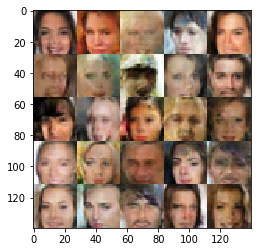

Epoch 3/10... Batch 420... Discriminator Loss: 0.9920... Generator Loss: 0.9706
Epoch 3/10... Batch 440... Discriminator Loss: 0.8026... Generator Loss: 1.8500
Epoch 3/10... Batch 460... Discriminator Loss: 0.9641... Generator Loss: 1.7957
Epoch 3/10... Batch 480... Discriminator Loss: 0.6355... Generator Loss: 2.4187
Epoch 3/10... Batch 500... Discriminator Loss: 1.0185... Generator Loss: 1.1768
Epoch 3/10... Batch 520... Discriminator Loss: 0.7241... Generator Loss: 1.7647
Epoch 3/10... Batch 540... Discriminator Loss: 1.0887... Generator Loss: 2.3750
Epoch 3/10... Batch 560... Discriminator Loss: 0.8310... Generator Loss: 1.4396
Epoch 3/10... Batch 580... Discriminator Loss: 0.8649... Generator Loss: 1.2016
Epoch 3/10... Batch 600... Discriminator Loss: 0.8717... Generator Loss: 1.0634


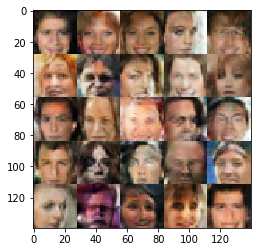

Epoch 3/10... Batch 620... Discriminator Loss: 1.1090... Generator Loss: 0.8112
Epoch 3/10... Batch 640... Discriminator Loss: 1.1114... Generator Loss: 0.7408
Epoch 3/10... Batch 660... Discriminator Loss: 1.6026... Generator Loss: 0.4352
Epoch 3/10... Batch 680... Discriminator Loss: 0.9330... Generator Loss: 1.9464
Epoch 3/10... Batch 700... Discriminator Loss: 0.9240... Generator Loss: 2.3302
Epoch 3/10... Batch 720... Discriminator Loss: 0.8043... Generator Loss: 2.0282
Epoch 3/10... Batch 740... Discriminator Loss: 0.9595... Generator Loss: 1.3905
Epoch 3/10... Batch 760... Discriminator Loss: 0.9153... Generator Loss: 1.1611
Epoch 3/10... Batch 780... Discriminator Loss: 0.9276... Generator Loss: 1.2725
Epoch 3/10... Batch 800... Discriminator Loss: 0.8931... Generator Loss: 0.9933


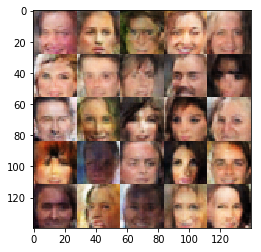

Epoch 3/10... Batch 820... Discriminator Loss: 1.6003... Generator Loss: 2.9000
Epoch 3/10... Batch 840... Discriminator Loss: 0.7568... Generator Loss: 1.4187
Epoch 3/10... Batch 860... Discriminator Loss: 1.5614... Generator Loss: 3.0730
Epoch 3/10... Batch 880... Discriminator Loss: 0.7219... Generator Loss: 2.0987
Epoch 3/10... Batch 900... Discriminator Loss: 0.8148... Generator Loss: 1.5185
Epoch 3/10... Batch 920... Discriminator Loss: 0.8673... Generator Loss: 1.7142
Epoch 3/10... Batch 940... Discriminator Loss: 0.8328... Generator Loss: 1.8132
Epoch 3/10... Batch 960... Discriminator Loss: 1.0081... Generator Loss: 1.9326
Epoch 3/10... Batch 980... Discriminator Loss: 1.3530... Generator Loss: 0.5181
Epoch 3/10... Batch 1000... Discriminator Loss: 0.7576... Generator Loss: 2.1290


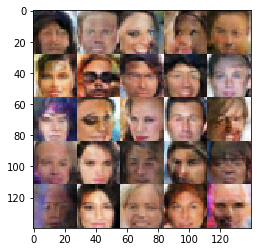

Epoch 3/10... Batch 1020... Discriminator Loss: 0.8291... Generator Loss: 2.2681
Epoch 3/10... Batch 1040... Discriminator Loss: 0.7382... Generator Loss: 1.3627
Epoch 3/10... Batch 1060... Discriminator Loss: 0.9951... Generator Loss: 0.9734
Epoch 3/10... Batch 1080... Discriminator Loss: 0.6996... Generator Loss: 1.5718
Epoch 3/10... Batch 1100... Discriminator Loss: 0.7193... Generator Loss: 2.3584
Epoch 3/10... Batch 1120... Discriminator Loss: 0.8606... Generator Loss: 1.2168
Epoch 3/10... Batch 1140... Discriminator Loss: 1.5857... Generator Loss: 0.4196
Epoch 3/10... Batch 1160... Discriminator Loss: 0.7716... Generator Loss: 1.3620
Epoch 3/10... Batch 1180... Discriminator Loss: 0.7263... Generator Loss: 2.0940
Epoch 3/10... Batch 1200... Discriminator Loss: 0.8475... Generator Loss: 1.0590


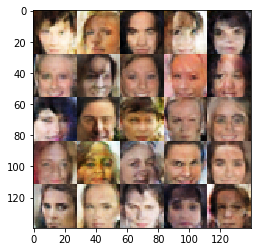

Epoch 3/10... Batch 1220... Discriminator Loss: 1.1343... Generator Loss: 0.7053
Epoch 3/10... Batch 1240... Discriminator Loss: 1.6292... Generator Loss: 0.3803
Epoch 3/10... Batch 1260... Discriminator Loss: 0.6685... Generator Loss: 1.6292
Epoch 3/10... Batch 1280... Discriminator Loss: 1.9040... Generator Loss: 0.2788
Epoch 3/10... Batch 1300... Discriminator Loss: 1.3164... Generator Loss: 0.5732
Epoch 3/10... Batch 1320... Discriminator Loss: 1.2611... Generator Loss: 2.1594
Epoch 3/10... Batch 1340... Discriminator Loss: 0.7940... Generator Loss: 1.9618
Epoch 3/10... Batch 1360... Discriminator Loss: 1.0361... Generator Loss: 0.8625
Epoch 3/10... Batch 1380... Discriminator Loss: 0.7275... Generator Loss: 2.0812
Epoch 3/10... Batch 1400... Discriminator Loss: 0.8595... Generator Loss: 1.2903


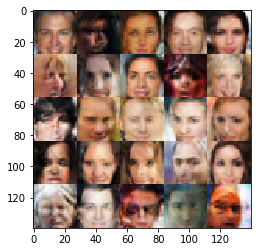

Epoch 3/10... Batch 1420... Discriminator Loss: 1.9827... Generator Loss: 3.1475
Epoch 3/10... Batch 1440... Discriminator Loss: 0.8027... Generator Loss: 1.9489
Epoch 3/10... Batch 1460... Discriminator Loss: 1.1044... Generator Loss: 0.7636
Epoch 3/10... Batch 1480... Discriminator Loss: 0.6342... Generator Loss: 1.8787
Epoch 3/10... Batch 1500... Discriminator Loss: 0.7912... Generator Loss: 1.2523
Epoch 3/10... Batch 1520... Discriminator Loss: 1.4588... Generator Loss: 0.5207
Epoch 3/10... Batch 1540... Discriminator Loss: 0.9109... Generator Loss: 3.0907
Epoch 3/10... Batch 1560... Discriminator Loss: 0.8355... Generator Loss: 1.0936
Epoch 3/10... Batch 1580... Discriminator Loss: 1.8519... Generator Loss: 2.5007
Epoch 4/10... Batch 20... Discriminator Loss: 0.8047... Generator Loss: 1.6858
Epoch 4/10... Batch 40... Discriminator Loss: 1.1676... Generator Loss: 2.3241
Epoch 4/10... Batch 60... Discriminator Loss: 1.1395... Generator Loss: 0.7264
Epoch 4/10... Batch 80... Discrimi

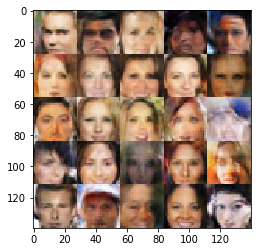

Epoch 4/10... Batch 220... Discriminator Loss: 0.8613... Generator Loss: 2.2979
Epoch 4/10... Batch 240... Discriminator Loss: 0.8897... Generator Loss: 2.7632
Epoch 4/10... Batch 260... Discriminator Loss: 1.4209... Generator Loss: 2.0968
Epoch 4/10... Batch 280... Discriminator Loss: 1.3783... Generator Loss: 0.5799
Epoch 4/10... Batch 300... Discriminator Loss: 0.7521... Generator Loss: 2.0961
Epoch 4/10... Batch 320... Discriminator Loss: 0.5739... Generator Loss: 1.8869
Epoch 4/10... Batch 340... Discriminator Loss: 0.6590... Generator Loss: 1.9266
Epoch 4/10... Batch 360... Discriminator Loss: 2.1256... Generator Loss: 0.2401
Epoch 4/10... Batch 380... Discriminator Loss: 0.9032... Generator Loss: 1.3109
Epoch 4/10... Batch 400... Discriminator Loss: 0.8075... Generator Loss: 1.8619


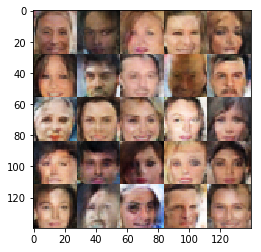

Epoch 4/10... Batch 420... Discriminator Loss: 0.8716... Generator Loss: 1.4389
Epoch 4/10... Batch 440... Discriminator Loss: 0.8259... Generator Loss: 1.1450
Epoch 4/10... Batch 460... Discriminator Loss: 1.0716... Generator Loss: 0.7958
Epoch 4/10... Batch 480... Discriminator Loss: 0.6778... Generator Loss: 1.6596
Epoch 4/10... Batch 500... Discriminator Loss: 0.8643... Generator Loss: 2.0655
Epoch 4/10... Batch 520... Discriminator Loss: 1.0076... Generator Loss: 0.8910
Epoch 4/10... Batch 540... Discriminator Loss: 1.2873... Generator Loss: 0.5788
Epoch 4/10... Batch 560... Discriminator Loss: 1.1365... Generator Loss: 1.7769
Epoch 4/10... Batch 580... Discriminator Loss: 1.0056... Generator Loss: 0.8637
Epoch 4/10... Batch 600... Discriminator Loss: 0.8804... Generator Loss: 1.5953


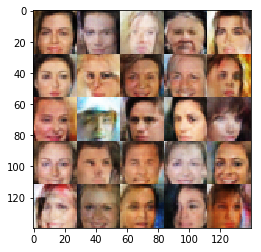

Epoch 4/10... Batch 620... Discriminator Loss: 0.5642... Generator Loss: 2.1754
Epoch 4/10... Batch 640... Discriminator Loss: 0.8752... Generator Loss: 2.6964
Epoch 4/10... Batch 660... Discriminator Loss: 0.9762... Generator Loss: 2.6303
Epoch 4/10... Batch 680... Discriminator Loss: 0.7798... Generator Loss: 1.2106
Epoch 4/10... Batch 700... Discriminator Loss: 1.6710... Generator Loss: 3.8813
Epoch 4/10... Batch 720... Discriminator Loss: 0.8858... Generator Loss: 1.2797
Epoch 4/10... Batch 740... Discriminator Loss: 1.5762... Generator Loss: 0.4055
Epoch 4/10... Batch 760... Discriminator Loss: 0.9142... Generator Loss: 2.0701
Epoch 4/10... Batch 780... Discriminator Loss: 0.7728... Generator Loss: 2.9149
Epoch 4/10... Batch 800... Discriminator Loss: 0.7882... Generator Loss: 1.1933


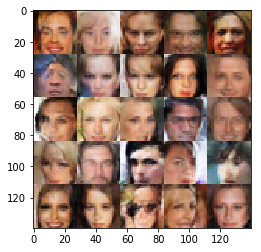

Epoch 4/10... Batch 820... Discriminator Loss: 0.8002... Generator Loss: 2.6179
Epoch 4/10... Batch 840... Discriminator Loss: 0.6509... Generator Loss: 1.9672
Epoch 4/10... Batch 860... Discriminator Loss: 1.0527... Generator Loss: 0.8215
Epoch 4/10... Batch 880... Discriminator Loss: 1.1564... Generator Loss: 0.6777
Epoch 4/10... Batch 900... Discriminator Loss: 0.6006... Generator Loss: 2.0205
Epoch 4/10... Batch 920... Discriminator Loss: 0.5521... Generator Loss: 2.3704
Epoch 4/10... Batch 940... Discriminator Loss: 0.9342... Generator Loss: 2.2780
Epoch 4/10... Batch 960... Discriminator Loss: 0.8202... Generator Loss: 1.2034
Epoch 4/10... Batch 980... Discriminator Loss: 0.9366... Generator Loss: 0.9614
Epoch 4/10... Batch 1000... Discriminator Loss: 0.7433... Generator Loss: 2.0312


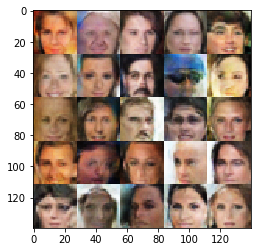

Epoch 4/10... Batch 1020... Discriminator Loss: 1.3564... Generator Loss: 0.5452
Epoch 4/10... Batch 1040... Discriminator Loss: 0.8878... Generator Loss: 1.4937
Epoch 4/10... Batch 1060... Discriminator Loss: 1.1074... Generator Loss: 0.7844
Epoch 4/10... Batch 1080... Discriminator Loss: 0.5502... Generator Loss: 2.2728
Epoch 4/10... Batch 1100... Discriminator Loss: 3.0907... Generator Loss: 1.8482
Epoch 4/10... Batch 1120... Discriminator Loss: 0.9272... Generator Loss: 1.2803
Epoch 4/10... Batch 1140... Discriminator Loss: 1.1546... Generator Loss: 2.8507
Epoch 4/10... Batch 1160... Discriminator Loss: 1.0635... Generator Loss: 0.7927
Epoch 4/10... Batch 1180... Discriminator Loss: 0.6856... Generator Loss: 1.5528
Epoch 4/10... Batch 1200... Discriminator Loss: 0.7990... Generator Loss: 2.4953


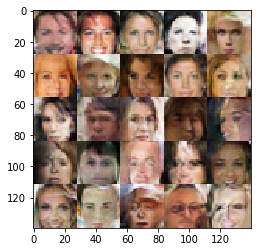

Epoch 4/10... Batch 1220... Discriminator Loss: 0.6811... Generator Loss: 1.6123
Epoch 4/10... Batch 1240... Discriminator Loss: 0.8515... Generator Loss: 1.0419
Epoch 4/10... Batch 1260... Discriminator Loss: 0.9749... Generator Loss: 2.0428
Epoch 4/10... Batch 1280... Discriminator Loss: 0.7510... Generator Loss: 2.7163
Epoch 4/10... Batch 1300... Discriminator Loss: 1.1008... Generator Loss: 0.8411
Epoch 4/10... Batch 1320... Discriminator Loss: 1.1159... Generator Loss: 0.7891
Epoch 4/10... Batch 1340... Discriminator Loss: 1.5307... Generator Loss: 0.4288
Epoch 4/10... Batch 1360... Discriminator Loss: 0.9925... Generator Loss: 0.8532
Epoch 4/10... Batch 1380... Discriminator Loss: 1.4204... Generator Loss: 2.8186
Epoch 4/10... Batch 1400... Discriminator Loss: 1.3929... Generator Loss: 0.5288


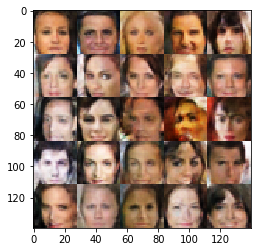

Epoch 4/10... Batch 1420... Discriminator Loss: 0.8138... Generator Loss: 2.1091
Epoch 4/10... Batch 1440... Discriminator Loss: 0.8292... Generator Loss: 1.1183
Epoch 4/10... Batch 1460... Discriminator Loss: 0.9270... Generator Loss: 1.0570
Epoch 4/10... Batch 1480... Discriminator Loss: 0.9772... Generator Loss: 0.8644
Epoch 4/10... Batch 1500... Discriminator Loss: 0.8840... Generator Loss: 3.4825
Epoch 4/10... Batch 1520... Discriminator Loss: 1.1836... Generator Loss: 0.6810
Epoch 4/10... Batch 1540... Discriminator Loss: 0.5675... Generator Loss: 1.9033
Epoch 4/10... Batch 1560... Discriminator Loss: 0.9303... Generator Loss: 1.4009
Epoch 4/10... Batch 1580... Discriminator Loss: 1.2348... Generator Loss: 0.6083
Epoch 5/10... Batch 20... Discriminator Loss: 0.7238... Generator Loss: 1.3740
Epoch 5/10... Batch 40... Discriminator Loss: 0.8012... Generator Loss: 1.8510
Epoch 5/10... Batch 60... Discriminator Loss: 0.5439... Generator Loss: 1.9487
Epoch 5/10... Batch 80... Discrimi

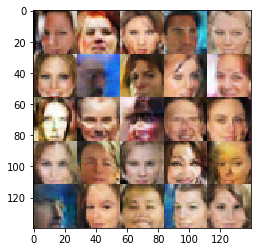

Epoch 5/10... Batch 220... Discriminator Loss: 0.9179... Generator Loss: 1.1063
Epoch 5/10... Batch 240... Discriminator Loss: 0.5874... Generator Loss: 1.8738
Epoch 5/10... Batch 260... Discriminator Loss: 0.7085... Generator Loss: 1.4922
Epoch 5/10... Batch 280... Discriminator Loss: 0.7489... Generator Loss: 1.3263
Epoch 5/10... Batch 300... Discriminator Loss: 1.1236... Generator Loss: 0.7487
Epoch 5/10... Batch 320... Discriminator Loss: 0.6740... Generator Loss: 3.6436
Epoch 5/10... Batch 340... Discriminator Loss: 0.8256... Generator Loss: 2.4738
Epoch 5/10... Batch 360... Discriminator Loss: 0.8288... Generator Loss: 1.8318
Epoch 5/10... Batch 380... Discriminator Loss: 0.6991... Generator Loss: 1.6133
Epoch 5/10... Batch 400... Discriminator Loss: 1.3227... Generator Loss: 0.6084


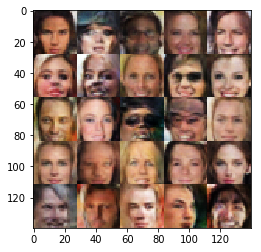

Epoch 5/10... Batch 420... Discriminator Loss: 1.4032... Generator Loss: 2.9637
Epoch 5/10... Batch 440... Discriminator Loss: 0.7384... Generator Loss: 1.2958
Epoch 5/10... Batch 460... Discriminator Loss: 0.6337... Generator Loss: 1.6715
Epoch 5/10... Batch 480... Discriminator Loss: 0.7202... Generator Loss: 1.3518
Epoch 5/10... Batch 500... Discriminator Loss: 0.7310... Generator Loss: 1.5263
Epoch 5/10... Batch 520... Discriminator Loss: 0.7085... Generator Loss: 2.6955
Epoch 5/10... Batch 540... Discriminator Loss: 0.8518... Generator Loss: 2.0535
Epoch 5/10... Batch 560... Discriminator Loss: 0.6537... Generator Loss: 2.0650
Epoch 5/10... Batch 580... Discriminator Loss: 0.9062... Generator Loss: 1.0700
Epoch 5/10... Batch 600... Discriminator Loss: 1.1282... Generator Loss: 0.7709


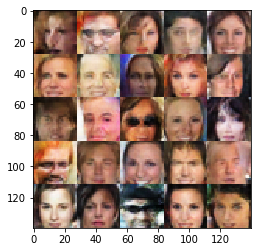

Epoch 5/10... Batch 620... Discriminator Loss: 0.7627... Generator Loss: 1.3872
Epoch 5/10... Batch 640... Discriminator Loss: 0.5705... Generator Loss: 2.0246
Epoch 5/10... Batch 660... Discriminator Loss: 0.6962... Generator Loss: 1.6276
Epoch 5/10... Batch 680... Discriminator Loss: 1.3080... Generator Loss: 0.6363
Epoch 5/10... Batch 700... Discriminator Loss: 2.3524... Generator Loss: 3.7569
Epoch 5/10... Batch 720... Discriminator Loss: 0.9821... Generator Loss: 1.5469
Epoch 5/10... Batch 740... Discriminator Loss: 0.7592... Generator Loss: 1.6989
Epoch 5/10... Batch 760... Discriminator Loss: 1.0796... Generator Loss: 0.7812
Epoch 5/10... Batch 780... Discriminator Loss: 0.6909... Generator Loss: 1.4415
Epoch 5/10... Batch 800... Discriminator Loss: 1.0324... Generator Loss: 0.9148


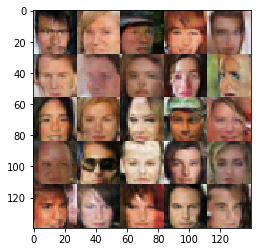

Epoch 5/10... Batch 820... Discriminator Loss: 0.9219... Generator Loss: 1.5289
Epoch 5/10... Batch 840... Discriminator Loss: 0.6981... Generator Loss: 1.4825
Epoch 5/10... Batch 860... Discriminator Loss: 1.2837... Generator Loss: 2.5025
Epoch 5/10... Batch 880... Discriminator Loss: 0.9423... Generator Loss: 0.9274
Epoch 5/10... Batch 900... Discriminator Loss: 0.8536... Generator Loss: 1.0978
Epoch 5/10... Batch 920... Discriminator Loss: 2.3512... Generator Loss: 0.2261
Epoch 5/10... Batch 940... Discriminator Loss: 0.6370... Generator Loss: 1.8368
Epoch 5/10... Batch 960... Discriminator Loss: 0.7646... Generator Loss: 2.7548
Epoch 5/10... Batch 980... Discriminator Loss: 0.9472... Generator Loss: 0.9263
Epoch 5/10... Batch 1000... Discriminator Loss: 0.6527... Generator Loss: 1.7511


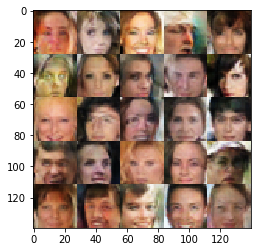

Epoch 5/10... Batch 1020... Discriminator Loss: 0.8672... Generator Loss: 1.3060
Epoch 5/10... Batch 1040... Discriminator Loss: 0.6400... Generator Loss: 2.5397
Epoch 5/10... Batch 1060... Discriminator Loss: 0.8116... Generator Loss: 1.1286
Epoch 5/10... Batch 1080... Discriminator Loss: 1.2119... Generator Loss: 1.9110
Epoch 5/10... Batch 1100... Discriminator Loss: 0.7098... Generator Loss: 2.0805
Epoch 5/10... Batch 1120... Discriminator Loss: 0.6586... Generator Loss: 1.9359
Epoch 5/10... Batch 1140... Discriminator Loss: 1.4312... Generator Loss: 2.2404
Epoch 5/10... Batch 1160... Discriminator Loss: 0.6691... Generator Loss: 2.2256
Epoch 5/10... Batch 1180... Discriminator Loss: 1.0737... Generator Loss: 2.8762
Epoch 5/10... Batch 1200... Discriminator Loss: 0.8206... Generator Loss: 1.1736


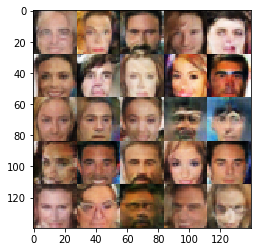

Epoch 5/10... Batch 1220... Discriminator Loss: 1.9605... Generator Loss: 4.0463
Epoch 5/10... Batch 1240... Discriminator Loss: 1.1675... Generator Loss: 0.7219
Epoch 5/10... Batch 1260... Discriminator Loss: 0.6347... Generator Loss: 1.7048
Epoch 5/10... Batch 1280... Discriminator Loss: 1.1115... Generator Loss: 0.7618
Epoch 5/10... Batch 1300... Discriminator Loss: 1.2776... Generator Loss: 3.1610
Epoch 5/10... Batch 1320... Discriminator Loss: 0.7683... Generator Loss: 1.2651
Epoch 5/10... Batch 1340... Discriminator Loss: 0.6203... Generator Loss: 1.8843
Epoch 5/10... Batch 1360... Discriminator Loss: 0.5516... Generator Loss: 1.9670
Epoch 5/10... Batch 1380... Discriminator Loss: 1.1721... Generator Loss: 3.6728
Epoch 5/10... Batch 1400... Discriminator Loss: 1.4659... Generator Loss: 0.4910


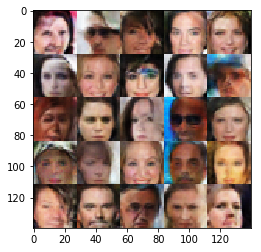

Epoch 5/10... Batch 1420... Discriminator Loss: 1.2444... Generator Loss: 0.6263
Epoch 5/10... Batch 1440... Discriminator Loss: 0.4639... Generator Loss: 2.5250
Epoch 5/10... Batch 1460... Discriminator Loss: 0.9288... Generator Loss: 0.9798
Epoch 5/10... Batch 1480... Discriminator Loss: 1.1428... Generator Loss: 2.3639
Epoch 5/10... Batch 1500... Discriminator Loss: 0.7012... Generator Loss: 2.4149
Epoch 5/10... Batch 1520... Discriminator Loss: 0.7478... Generator Loss: 1.7434
Epoch 5/10... Batch 1540... Discriminator Loss: 0.6507... Generator Loss: 1.6286
Epoch 5/10... Batch 1560... Discriminator Loss: 1.2352... Generator Loss: 0.6765
Epoch 5/10... Batch 1580... Discriminator Loss: 0.5331... Generator Loss: 2.1144
Epoch 6/10... Batch 20... Discriminator Loss: 2.2964... Generator Loss: 0.2571
Epoch 6/10... Batch 40... Discriminator Loss: 1.1660... Generator Loss: 0.7040
Epoch 6/10... Batch 60... Discriminator Loss: 0.7030... Generator Loss: 1.3984
Epoch 6/10... Batch 80... Discrimi

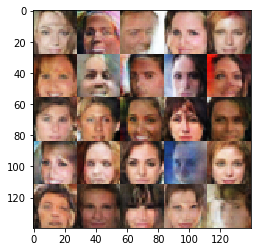

Epoch 6/10... Batch 220... Discriminator Loss: 1.7010... Generator Loss: 0.4187
Epoch 6/10... Batch 240... Discriminator Loss: 1.5926... Generator Loss: 0.4298
Epoch 6/10... Batch 260... Discriminator Loss: 1.7238... Generator Loss: 0.8751
Epoch 6/10... Batch 280... Discriminator Loss: 0.9870... Generator Loss: 0.9460
Epoch 6/10... Batch 300... Discriminator Loss: 0.7373... Generator Loss: 1.6971
Epoch 6/10... Batch 320... Discriminator Loss: 0.5657... Generator Loss: 1.9448
Epoch 6/10... Batch 340... Discriminator Loss: 0.9206... Generator Loss: 2.7525
Epoch 6/10... Batch 360... Discriminator Loss: 0.8310... Generator Loss: 1.1683
Epoch 6/10... Batch 380... Discriminator Loss: 1.2870... Generator Loss: 1.8392
Epoch 6/10... Batch 400... Discriminator Loss: 0.7873... Generator Loss: 1.3648


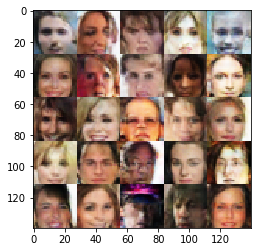

Epoch 6/10... Batch 420... Discriminator Loss: 0.8532... Generator Loss: 2.1064
Epoch 6/10... Batch 440... Discriminator Loss: 1.2987... Generator Loss: 2.8343
Epoch 6/10... Batch 460... Discriminator Loss: 1.2131... Generator Loss: 0.6804
Epoch 6/10... Batch 480... Discriminator Loss: 1.3526... Generator Loss: 2.7082
Epoch 6/10... Batch 500... Discriminator Loss: 0.7916... Generator Loss: 1.2434
Epoch 6/10... Batch 520... Discriminator Loss: 0.6834... Generator Loss: 1.4776
Epoch 6/10... Batch 540... Discriminator Loss: 1.3510... Generator Loss: 0.5438
Epoch 6/10... Batch 560... Discriminator Loss: 1.1237... Generator Loss: 3.4208
Epoch 6/10... Batch 580... Discriminator Loss: 1.5561... Generator Loss: 0.4583
Epoch 6/10... Batch 600... Discriminator Loss: 0.9947... Generator Loss: 2.2036


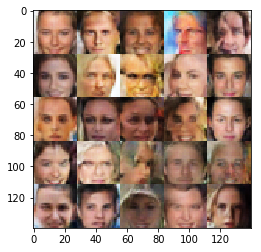

Epoch 6/10... Batch 620... Discriminator Loss: 0.6544... Generator Loss: 1.5230
Epoch 6/10... Batch 640... Discriminator Loss: 1.4455... Generator Loss: 0.5431
Epoch 6/10... Batch 660... Discriminator Loss: 0.6942... Generator Loss: 1.9454
Epoch 6/10... Batch 680... Discriminator Loss: 0.7637... Generator Loss: 1.4960
Epoch 6/10... Batch 700... Discriminator Loss: 0.9359... Generator Loss: 1.6365
Epoch 6/10... Batch 720... Discriminator Loss: 1.1139... Generator Loss: 0.8359
Epoch 6/10... Batch 740... Discriminator Loss: 0.8608... Generator Loss: 1.1461
Epoch 6/10... Batch 760... Discriminator Loss: 0.9317... Generator Loss: 1.0087
Epoch 6/10... Batch 780... Discriminator Loss: 0.9375... Generator Loss: 1.0051
Epoch 6/10... Batch 800... Discriminator Loss: 0.9206... Generator Loss: 1.1433


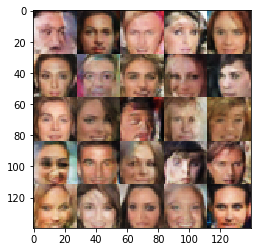

Epoch 6/10... Batch 820... Discriminator Loss: 0.8826... Generator Loss: 1.9929
Epoch 6/10... Batch 840... Discriminator Loss: 0.6905... Generator Loss: 1.6102
Epoch 6/10... Batch 860... Discriminator Loss: 1.1389... Generator Loss: 3.1481
Epoch 6/10... Batch 880... Discriminator Loss: 0.8481... Generator Loss: 1.1030
Epoch 6/10... Batch 900... Discriminator Loss: 1.9378... Generator Loss: 0.3331
Epoch 6/10... Batch 920... Discriminator Loss: 1.7796... Generator Loss: 0.3486
Epoch 6/10... Batch 940... Discriminator Loss: 0.6407... Generator Loss: 1.8740
Epoch 6/10... Batch 960... Discriminator Loss: 0.5827... Generator Loss: 3.4729
Epoch 6/10... Batch 980... Discriminator Loss: 1.0608... Generator Loss: 0.8219
Epoch 6/10... Batch 1000... Discriminator Loss: 1.2652... Generator Loss: 0.6076


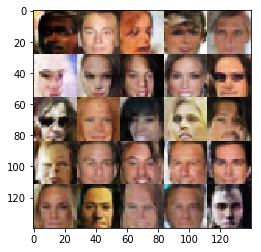

Epoch 6/10... Batch 1020... Discriminator Loss: 0.5778... Generator Loss: 2.5535
Epoch 6/10... Batch 1040... Discriminator Loss: 1.2578... Generator Loss: 0.6627
Epoch 6/10... Batch 1060... Discriminator Loss: 0.6646... Generator Loss: 1.9289
Epoch 6/10... Batch 1080... Discriminator Loss: 0.7873... Generator Loss: 1.4436
Epoch 6/10... Batch 1100... Discriminator Loss: 1.6871... Generator Loss: 3.0874
Epoch 6/10... Batch 1120... Discriminator Loss: 0.8892... Generator Loss: 1.0614
Epoch 6/10... Batch 1140... Discriminator Loss: 0.6165... Generator Loss: 2.6415
Epoch 6/10... Batch 1160... Discriminator Loss: 0.8790... Generator Loss: 1.0402
Epoch 6/10... Batch 1180... Discriminator Loss: 0.6201... Generator Loss: 2.0053
Epoch 6/10... Batch 1200... Discriminator Loss: 0.6467... Generator Loss: 1.7235


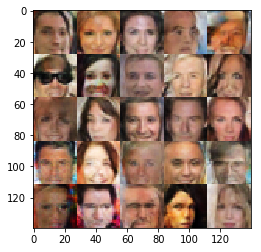

Epoch 6/10... Batch 1220... Discriminator Loss: 0.6980... Generator Loss: 3.1312
Epoch 6/10... Batch 1240... Discriminator Loss: 2.1603... Generator Loss: 0.2385
Epoch 6/10... Batch 1260... Discriminator Loss: 0.6668... Generator Loss: 2.8212
Epoch 6/10... Batch 1280... Discriminator Loss: 0.8644... Generator Loss: 2.1914
Epoch 6/10... Batch 1300... Discriminator Loss: 1.4454... Generator Loss: 0.5285
Epoch 6/10... Batch 1320... Discriminator Loss: 1.0022... Generator Loss: 1.6161
Epoch 6/10... Batch 1340... Discriminator Loss: 0.9106... Generator Loss: 1.0563
Epoch 6/10... Batch 1360... Discriminator Loss: 0.6271... Generator Loss: 1.6945
Epoch 6/10... Batch 1380... Discriminator Loss: 1.1114... Generator Loss: 3.0573
Epoch 6/10... Batch 1400... Discriminator Loss: 1.0898... Generator Loss: 3.3526


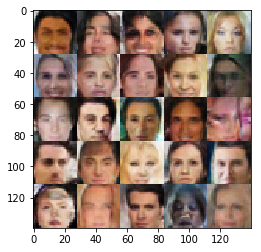

Epoch 6/10... Batch 1420... Discriminator Loss: 0.8044... Generator Loss: 1.1792
Epoch 6/10... Batch 1440... Discriminator Loss: 1.0376... Generator Loss: 0.9341
Epoch 6/10... Batch 1460... Discriminator Loss: 0.8260... Generator Loss: 1.1601
Epoch 6/10... Batch 1480... Discriminator Loss: 0.7743... Generator Loss: 1.2643
Epoch 6/10... Batch 1500... Discriminator Loss: 0.6879... Generator Loss: 1.5028
Epoch 6/10... Batch 1520... Discriminator Loss: 2.0095... Generator Loss: 0.2715
Epoch 6/10... Batch 1540... Discriminator Loss: 0.6377... Generator Loss: 2.1813
Epoch 6/10... Batch 1560... Discriminator Loss: 0.5865... Generator Loss: 2.2530
Epoch 6/10... Batch 1580... Discriminator Loss: 0.6121... Generator Loss: 1.8122
Epoch 7/10... Batch 20... Discriminator Loss: 0.5722... Generator Loss: 1.8625
Epoch 7/10... Batch 40... Discriminator Loss: 1.5097... Generator Loss: 0.5862
Epoch 7/10... Batch 60... Discriminator Loss: 0.8412... Generator Loss: 1.5664
Epoch 7/10... Batch 80... Discrimi

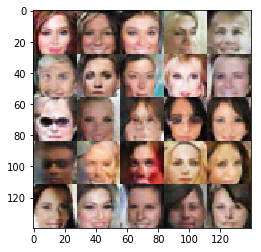

Epoch 7/10... Batch 220... Discriminator Loss: 1.4354... Generator Loss: 0.6111
Epoch 7/10... Batch 240... Discriminator Loss: 0.8919... Generator Loss: 1.0581
Epoch 7/10... Batch 260... Discriminator Loss: 0.8393... Generator Loss: 1.7373
Epoch 7/10... Batch 280... Discriminator Loss: 1.4975... Generator Loss: 0.5244
Epoch 7/10... Batch 300... Discriminator Loss: 0.9879... Generator Loss: 0.9312
Epoch 7/10... Batch 320... Discriminator Loss: 1.1051... Generator Loss: 0.8230
Epoch 7/10... Batch 340... Discriminator Loss: 1.0610... Generator Loss: 2.5340
Epoch 7/10... Batch 360... Discriminator Loss: 1.1647... Generator Loss: 3.0263
Epoch 7/10... Batch 380... Discriminator Loss: 0.8858... Generator Loss: 1.0212
Epoch 7/10... Batch 400... Discriminator Loss: 1.0119... Generator Loss: 1.1114


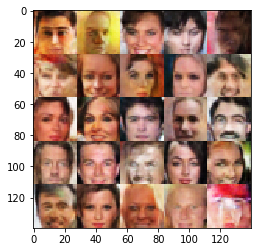

Epoch 7/10... Batch 420... Discriminator Loss: 0.6579... Generator Loss: 1.6479
Epoch 7/10... Batch 440... Discriminator Loss: 1.4269... Generator Loss: 0.5564
Epoch 7/10... Batch 460... Discriminator Loss: 0.8565... Generator Loss: 1.1321
Epoch 7/10... Batch 480... Discriminator Loss: 1.5791... Generator Loss: 0.4392
Epoch 7/10... Batch 500... Discriminator Loss: 0.6954... Generator Loss: 1.4199
Epoch 7/10... Batch 520... Discriminator Loss: 0.7391... Generator Loss: 1.4153
Epoch 7/10... Batch 540... Discriminator Loss: 0.8539... Generator Loss: 1.1786
Epoch 7/10... Batch 560... Discriminator Loss: 0.7405... Generator Loss: 1.6132
Epoch 7/10... Batch 580... Discriminator Loss: 0.6439... Generator Loss: 2.3200
Epoch 7/10... Batch 600... Discriminator Loss: 1.1890... Generator Loss: 0.7171


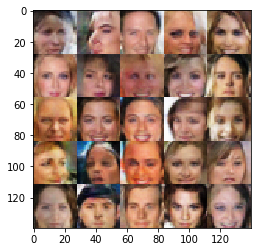

Epoch 7/10... Batch 620... Discriminator Loss: 1.2921... Generator Loss: 0.6353
Epoch 7/10... Batch 640... Discriminator Loss: 2.1363... Generator Loss: 0.2671
Epoch 7/10... Batch 660... Discriminator Loss: 0.8468... Generator Loss: 1.1518
Epoch 7/10... Batch 680... Discriminator Loss: 1.0968... Generator Loss: 0.8113
Epoch 7/10... Batch 700... Discriminator Loss: 0.7048... Generator Loss: 2.0416
Epoch 7/10... Batch 720... Discriminator Loss: 0.6371... Generator Loss: 1.6591
Epoch 7/10... Batch 740... Discriminator Loss: 0.9646... Generator Loss: 1.0625
Epoch 7/10... Batch 760... Discriminator Loss: 1.7578... Generator Loss: 0.4361
Epoch 7/10... Batch 780... Discriminator Loss: 1.3771... Generator Loss: 0.5674
Epoch 7/10... Batch 800... Discriminator Loss: 1.3794... Generator Loss: 0.5908


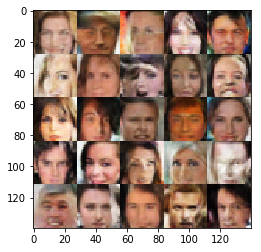

Epoch 7/10... Batch 820... Discriminator Loss: 0.7534... Generator Loss: 1.4326
Epoch 7/10... Batch 840... Discriminator Loss: 0.6753... Generator Loss: 1.4673
Epoch 7/10... Batch 860... Discriminator Loss: 0.8527... Generator Loss: 1.9934
Epoch 7/10... Batch 880... Discriminator Loss: 1.1323... Generator Loss: 0.7932
Epoch 7/10... Batch 900... Discriminator Loss: 0.5986... Generator Loss: 1.6903
Epoch 7/10... Batch 920... Discriminator Loss: 1.0422... Generator Loss: 0.9329
Epoch 7/10... Batch 940... Discriminator Loss: 0.8572... Generator Loss: 2.0476
Epoch 7/10... Batch 960... Discriminator Loss: 0.6581... Generator Loss: 1.5896
Epoch 7/10... Batch 980... Discriminator Loss: 0.5035... Generator Loss: 3.1537
Epoch 7/10... Batch 1000... Discriminator Loss: 0.9080... Generator Loss: 1.8562


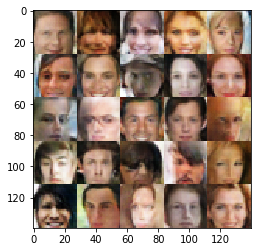

Epoch 7/10... Batch 1020... Discriminator Loss: 0.7311... Generator Loss: 2.3587
Epoch 7/10... Batch 1040... Discriminator Loss: 1.0005... Generator Loss: 0.8562
Epoch 7/10... Batch 1060... Discriminator Loss: 1.2678... Generator Loss: 2.6473
Epoch 7/10... Batch 1080... Discriminator Loss: 0.5819... Generator Loss: 1.8660
Epoch 7/10... Batch 1100... Discriminator Loss: 0.7064... Generator Loss: 1.4348
Epoch 7/10... Batch 1120... Discriminator Loss: 1.0517... Generator Loss: 0.8321
Epoch 7/10... Batch 1140... Discriminator Loss: 0.8716... Generator Loss: 2.3744
Epoch 7/10... Batch 1160... Discriminator Loss: 0.8736... Generator Loss: 1.7894
Epoch 7/10... Batch 1180... Discriminator Loss: 0.6942... Generator Loss: 1.5652
Epoch 7/10... Batch 1200... Discriminator Loss: 0.6019... Generator Loss: 1.8061


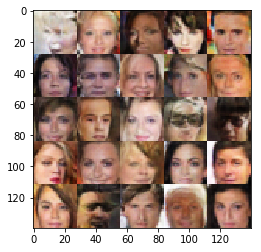

Epoch 7/10... Batch 1220... Discriminator Loss: 0.7292... Generator Loss: 1.4524
Epoch 7/10... Batch 1240... Discriminator Loss: 1.3150... Generator Loss: 0.6637
Epoch 7/10... Batch 1260... Discriminator Loss: 0.9331... Generator Loss: 1.8303
Epoch 7/10... Batch 1280... Discriminator Loss: 0.7567... Generator Loss: 2.5323
Epoch 7/10... Batch 1300... Discriminator Loss: 0.7965... Generator Loss: 1.1800
Epoch 7/10... Batch 1320... Discriminator Loss: 1.0080... Generator Loss: 3.1866
Epoch 7/10... Batch 1340... Discriminator Loss: 1.4121... Generator Loss: 2.5165
Epoch 7/10... Batch 1360... Discriminator Loss: 1.0426... Generator Loss: 0.8405
Epoch 7/10... Batch 1380... Discriminator Loss: 1.0114... Generator Loss: 2.6045
Epoch 7/10... Batch 1400... Discriminator Loss: 0.8548... Generator Loss: 1.1584


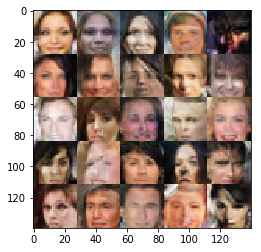

Epoch 7/10... Batch 1420... Discriminator Loss: 0.8202... Generator Loss: 1.2089
Epoch 7/10... Batch 1440... Discriminator Loss: 0.7437... Generator Loss: 1.2668
Epoch 7/10... Batch 1460... Discriminator Loss: 0.7025... Generator Loss: 2.0679
Epoch 7/10... Batch 1480... Discriminator Loss: 1.4395... Generator Loss: 0.5593
Epoch 7/10... Batch 1500... Discriminator Loss: 1.1548... Generator Loss: 2.5025
Epoch 7/10... Batch 1520... Discriminator Loss: 2.2378... Generator Loss: 0.2292
Epoch 7/10... Batch 1540... Discriminator Loss: 0.6713... Generator Loss: 1.5848
Epoch 7/10... Batch 1560... Discriminator Loss: 0.6258... Generator Loss: 1.6279
Epoch 7/10... Batch 1580... Discriminator Loss: 0.6512... Generator Loss: 1.5970
Epoch 8/10... Batch 20... Discriminator Loss: 0.5926... Generator Loss: 1.9290
Epoch 8/10... Batch 40... Discriminator Loss: 0.5125... Generator Loss: 2.2311
Epoch 8/10... Batch 60... Discriminator Loss: 1.8808... Generator Loss: 0.3451
Epoch 8/10... Batch 80... Discrimi

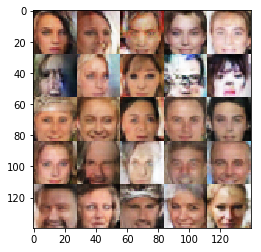

Epoch 8/10... Batch 220... Discriminator Loss: 1.0841... Generator Loss: 0.7935
Epoch 8/10... Batch 240... Discriminator Loss: 0.5140... Generator Loss: 2.2350
Epoch 8/10... Batch 260... Discriminator Loss: 0.8857... Generator Loss: 2.7973
Epoch 8/10... Batch 280... Discriminator Loss: 0.5950... Generator Loss: 2.2191
Epoch 8/10... Batch 300... Discriminator Loss: 1.3016... Generator Loss: 0.6177
Epoch 8/10... Batch 320... Discriminator Loss: 0.6608... Generator Loss: 1.5633
Epoch 8/10... Batch 340... Discriminator Loss: 0.8591... Generator Loss: 2.2625
Epoch 8/10... Batch 360... Discriminator Loss: 0.8380... Generator Loss: 1.3276
Epoch 8/10... Batch 380... Discriminator Loss: 0.8847... Generator Loss: 1.7166
Epoch 8/10... Batch 400... Discriminator Loss: 0.7185... Generator Loss: 1.5051


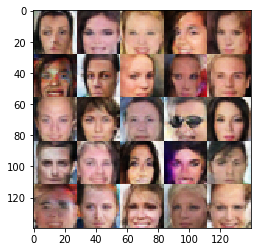

Epoch 8/10... Batch 420... Discriminator Loss: 0.9187... Generator Loss: 2.7688
Epoch 8/10... Batch 440... Discriminator Loss: 0.9790... Generator Loss: 0.9703
Epoch 8/10... Batch 460... Discriminator Loss: 0.7479... Generator Loss: 1.3633
Epoch 8/10... Batch 480... Discriminator Loss: 0.6734... Generator Loss: 1.5240
Epoch 8/10... Batch 500... Discriminator Loss: 1.2990... Generator Loss: 0.6538
Epoch 8/10... Batch 520... Discriminator Loss: 0.6958... Generator Loss: 1.9101
Epoch 8/10... Batch 540... Discriminator Loss: 1.0187... Generator Loss: 2.0562
Epoch 8/10... Batch 560... Discriminator Loss: 0.9759... Generator Loss: 3.5852
Epoch 8/10... Batch 580... Discriminator Loss: 1.7390... Generator Loss: 3.5682
Epoch 8/10... Batch 600... Discriminator Loss: 0.9057... Generator Loss: 1.6441


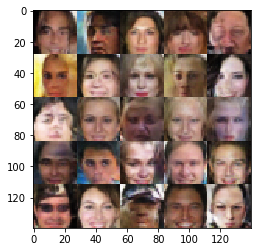

Epoch 8/10... Batch 620... Discriminator Loss: 1.3879... Generator Loss: 0.5601
Epoch 8/10... Batch 640... Discriminator Loss: 0.7614... Generator Loss: 1.5545
Epoch 8/10... Batch 660... Discriminator Loss: 0.6762... Generator Loss: 1.5010
Epoch 8/10... Batch 680... Discriminator Loss: 1.8992... Generator Loss: 0.3168
Epoch 8/10... Batch 700... Discriminator Loss: 0.5755... Generator Loss: 2.6820
Epoch 8/10... Batch 720... Discriminator Loss: 0.8643... Generator Loss: 1.1194
Epoch 8/10... Batch 740... Discriminator Loss: 1.8242... Generator Loss: 0.3828
Epoch 8/10... Batch 760... Discriminator Loss: 0.9694... Generator Loss: 2.6760
Epoch 8/10... Batch 780... Discriminator Loss: 0.5410... Generator Loss: 2.0458
Epoch 8/10... Batch 800... Discriminator Loss: 1.3304... Generator Loss: 0.6208


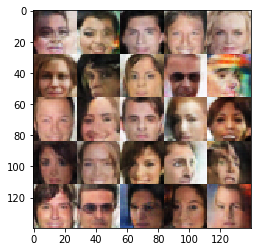

Epoch 8/10... Batch 820... Discriminator Loss: 0.8692... Generator Loss: 1.0852
Epoch 8/10... Batch 840... Discriminator Loss: 0.9785... Generator Loss: 1.0196
Epoch 8/10... Batch 860... Discriminator Loss: 1.4651... Generator Loss: 0.6475
Epoch 8/10... Batch 880... Discriminator Loss: 1.4992... Generator Loss: 0.4965
Epoch 8/10... Batch 900... Discriminator Loss: 0.7357... Generator Loss: 1.7801
Epoch 8/10... Batch 920... Discriminator Loss: 0.7303... Generator Loss: 1.3894
Epoch 8/10... Batch 940... Discriminator Loss: 0.6289... Generator Loss: 1.8404
Epoch 8/10... Batch 960... Discriminator Loss: 0.6751... Generator Loss: 1.5441
Epoch 8/10... Batch 980... Discriminator Loss: 1.0411... Generator Loss: 0.8916
Epoch 8/10... Batch 1000... Discriminator Loss: 1.0367... Generator Loss: 0.8576


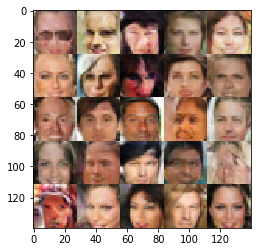

Epoch 8/10... Batch 1020... Discriminator Loss: 0.8540... Generator Loss: 1.3555
Epoch 8/10... Batch 1040... Discriminator Loss: 1.1833... Generator Loss: 0.7393
Epoch 8/10... Batch 1060... Discriminator Loss: 0.7303... Generator Loss: 1.4220
Epoch 8/10... Batch 1080... Discriminator Loss: 0.6541... Generator Loss: 2.1908
Epoch 8/10... Batch 1100... Discriminator Loss: 0.8119... Generator Loss: 1.4877
Epoch 8/10... Batch 1120... Discriminator Loss: 0.4008... Generator Loss: 3.2594
Epoch 8/10... Batch 1140... Discriminator Loss: 0.6319... Generator Loss: 1.6583
Epoch 8/10... Batch 1160... Discriminator Loss: 3.4695... Generator Loss: 0.1448
Epoch 8/10... Batch 1180... Discriminator Loss: 1.0591... Generator Loss: 2.1903
Epoch 8/10... Batch 1200... Discriminator Loss: 1.1017... Generator Loss: 0.7921


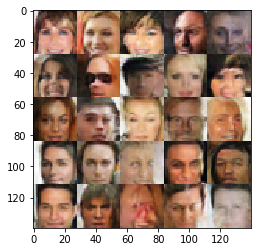

Epoch 8/10... Batch 1220... Discriminator Loss: 0.8396... Generator Loss: 2.1512
Epoch 8/10... Batch 1240... Discriminator Loss: 1.0644... Generator Loss: 0.8422
Epoch 8/10... Batch 1260... Discriminator Loss: 0.9498... Generator Loss: 0.9832
Epoch 8/10... Batch 1280... Discriminator Loss: 1.0264... Generator Loss: 0.9044
Epoch 8/10... Batch 1300... Discriminator Loss: 0.7198... Generator Loss: 1.3587
Epoch 8/10... Batch 1320... Discriminator Loss: 1.4531... Generator Loss: 0.4977
Epoch 8/10... Batch 1340... Discriminator Loss: 0.7790... Generator Loss: 2.7843
Epoch 8/10... Batch 1360... Discriminator Loss: 1.1679... Generator Loss: 0.7420
Epoch 8/10... Batch 1380... Discriminator Loss: 1.0684... Generator Loss: 2.5774
Epoch 8/10... Batch 1400... Discriminator Loss: 1.0477... Generator Loss: 0.8361


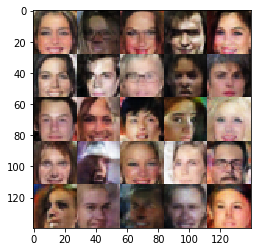

Epoch 8/10... Batch 1420... Discriminator Loss: 0.6732... Generator Loss: 1.9889
Epoch 8/10... Batch 1440... Discriminator Loss: 0.7830... Generator Loss: 1.4869
Epoch 8/10... Batch 1460... Discriminator Loss: 1.2285... Generator Loss: 3.0497
Epoch 8/10... Batch 1480... Discriminator Loss: 1.1961... Generator Loss: 3.2633
Epoch 8/10... Batch 1500... Discriminator Loss: 0.5495... Generator Loss: 2.2250
Epoch 8/10... Batch 1520... Discriminator Loss: 1.4822... Generator Loss: 0.5127
Epoch 8/10... Batch 1540... Discriminator Loss: 0.8843... Generator Loss: 1.2026
Epoch 8/10... Batch 1560... Discriminator Loss: 0.5850... Generator Loss: 2.2927
Epoch 8/10... Batch 1580... Discriminator Loss: 0.7867... Generator Loss: 1.2406
Epoch 9/10... Batch 20... Discriminator Loss: 0.8433... Generator Loss: 1.1612
Epoch 9/10... Batch 40... Discriminator Loss: 0.9574... Generator Loss: 1.0416
Epoch 9/10... Batch 60... Discriminator Loss: 0.9444... Generator Loss: 2.2795
Epoch 9/10... Batch 80... Discrimi

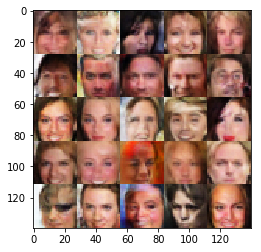

Epoch 9/10... Batch 220... Discriminator Loss: 0.6176... Generator Loss: 1.9231
Epoch 9/10... Batch 240... Discriminator Loss: 0.6644... Generator Loss: 1.8292
Epoch 9/10... Batch 260... Discriminator Loss: 0.6797... Generator Loss: 2.5662
Epoch 9/10... Batch 280... Discriminator Loss: 1.5977... Generator Loss: 3.5117
Epoch 9/10... Batch 300... Discriminator Loss: 0.6713... Generator Loss: 1.4847
Epoch 9/10... Batch 320... Discriminator Loss: 1.2515... Generator Loss: 0.6156
Epoch 9/10... Batch 340... Discriminator Loss: 0.6971... Generator Loss: 1.9037
Epoch 9/10... Batch 360... Discriminator Loss: 1.0440... Generator Loss: 0.8772
Epoch 9/10... Batch 380... Discriminator Loss: 0.7706... Generator Loss: 1.7057
Epoch 9/10... Batch 400... Discriminator Loss: 1.4213... Generator Loss: 0.5461


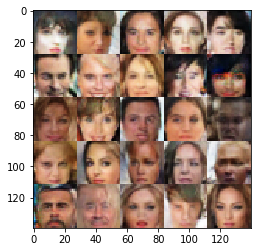

Epoch 9/10... Batch 420... Discriminator Loss: 0.6896... Generator Loss: 1.5884
Epoch 9/10... Batch 440... Discriminator Loss: 0.6286... Generator Loss: 1.9600
Epoch 9/10... Batch 460... Discriminator Loss: 0.6727... Generator Loss: 1.7865
Epoch 9/10... Batch 480... Discriminator Loss: 0.4792... Generator Loss: 2.6443
Epoch 9/10... Batch 500... Discriminator Loss: 2.2939... Generator Loss: 3.6045
Epoch 9/10... Batch 520... Discriminator Loss: 0.9457... Generator Loss: 1.0188
Epoch 9/10... Batch 540... Discriminator Loss: 0.9678... Generator Loss: 0.9887
Epoch 9/10... Batch 560... Discriminator Loss: 0.6470... Generator Loss: 2.1886
Epoch 9/10... Batch 580... Discriminator Loss: 0.5043... Generator Loss: 2.2747
Epoch 9/10... Batch 600... Discriminator Loss: 0.6512... Generator Loss: 1.6050


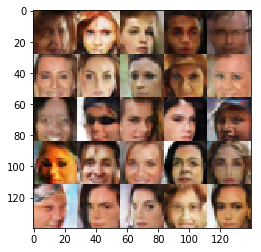

Epoch 9/10... Batch 620... Discriminator Loss: 1.4238... Generator Loss: 0.5505
Epoch 9/10... Batch 640... Discriminator Loss: 0.7663... Generator Loss: 1.2539
Epoch 9/10... Batch 660... Discriminator Loss: 0.6180... Generator Loss: 2.2190
Epoch 9/10... Batch 680... Discriminator Loss: 1.1182... Generator Loss: 0.8307
Epoch 9/10... Batch 700... Discriminator Loss: 1.6528... Generator Loss: 3.2157
Epoch 9/10... Batch 720... Discriminator Loss: 0.6521... Generator Loss: 1.5931
Epoch 9/10... Batch 740... Discriminator Loss: 0.7822... Generator Loss: 2.7697
Epoch 9/10... Batch 760... Discriminator Loss: 0.9510... Generator Loss: 1.0166
Epoch 9/10... Batch 780... Discriminator Loss: 0.9321... Generator Loss: 1.8765
Epoch 9/10... Batch 800... Discriminator Loss: 0.5757... Generator Loss: 1.7879


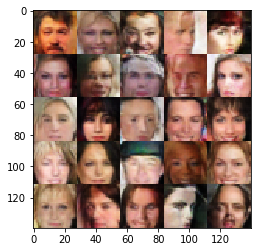

Epoch 9/10... Batch 820... Discriminator Loss: 0.9773... Generator Loss: 0.9082
Epoch 9/10... Batch 840... Discriminator Loss: 0.9435... Generator Loss: 0.9555
Epoch 9/10... Batch 860... Discriminator Loss: 0.8598... Generator Loss: 2.6378
Epoch 9/10... Batch 880... Discriminator Loss: 1.7065... Generator Loss: 0.4280
Epoch 9/10... Batch 900... Discriminator Loss: 0.9687... Generator Loss: 0.9476
Epoch 9/10... Batch 920... Discriminator Loss: 1.2543... Generator Loss: 0.6783
Epoch 9/10... Batch 940... Discriminator Loss: 1.0599... Generator Loss: 0.8123
Epoch 9/10... Batch 960... Discriminator Loss: 0.7837... Generator Loss: 1.9403
Epoch 9/10... Batch 980... Discriminator Loss: 1.1836... Generator Loss: 0.7163
Epoch 9/10... Batch 1000... Discriminator Loss: 1.8341... Generator Loss: 0.3554


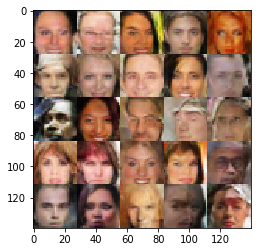

Epoch 9/10... Batch 1020... Discriminator Loss: 0.7023... Generator Loss: 1.6778
Epoch 9/10... Batch 1040... Discriminator Loss: 1.4552... Generator Loss: 0.5740
Epoch 9/10... Batch 1060... Discriminator Loss: 0.7035... Generator Loss: 1.5228
Epoch 9/10... Batch 1080... Discriminator Loss: 0.7151... Generator Loss: 1.4575
Epoch 9/10... Batch 1100... Discriminator Loss: 0.7686... Generator Loss: 1.2990
Epoch 9/10... Batch 1120... Discriminator Loss: 0.8979... Generator Loss: 2.5585
Epoch 9/10... Batch 1140... Discriminator Loss: 0.8191... Generator Loss: 1.8659
Epoch 9/10... Batch 1160... Discriminator Loss: 1.9272... Generator Loss: 0.3195
Epoch 9/10... Batch 1180... Discriminator Loss: 1.6851... Generator Loss: 3.0710
Epoch 9/10... Batch 1200... Discriminator Loss: 0.9654... Generator Loss: 2.4264


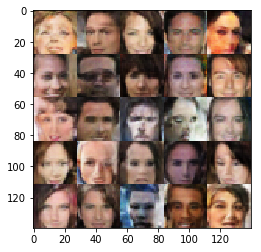

Epoch 9/10... Batch 1220... Discriminator Loss: 0.5711... Generator Loss: 1.9911
Epoch 9/10... Batch 1240... Discriminator Loss: 0.5663... Generator Loss: 3.7605
Epoch 9/10... Batch 1260... Discriminator Loss: 0.6719... Generator Loss: 1.4907
Epoch 9/10... Batch 1280... Discriminator Loss: 0.8520... Generator Loss: 1.2103
Epoch 9/10... Batch 1300... Discriminator Loss: 0.7505... Generator Loss: 1.2994
Epoch 9/10... Batch 1320... Discriminator Loss: 1.3600... Generator Loss: 0.5599
Epoch 9/10... Batch 1340... Discriminator Loss: 0.6757... Generator Loss: 1.5325
Epoch 9/10... Batch 1360... Discriminator Loss: 0.7855... Generator Loss: 1.2160
Epoch 9/10... Batch 1380... Discriminator Loss: 1.2344... Generator Loss: 3.0462
Epoch 9/10... Batch 1400... Discriminator Loss: 0.7744... Generator Loss: 1.3601


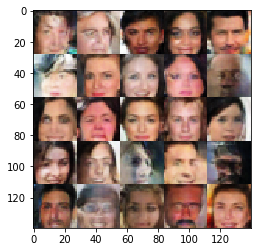

Epoch 9/10... Batch 1420... Discriminator Loss: 0.6183... Generator Loss: 1.7011
Epoch 9/10... Batch 1440... Discriminator Loss: 0.6495... Generator Loss: 1.5073
Epoch 9/10... Batch 1460... Discriminator Loss: 0.9642... Generator Loss: 2.1515
Epoch 9/10... Batch 1480... Discriminator Loss: 1.3416... Generator Loss: 0.6096
Epoch 9/10... Batch 1500... Discriminator Loss: 0.5145... Generator Loss: 2.2001
Epoch 9/10... Batch 1520... Discriminator Loss: 1.3655... Generator Loss: 0.5984
Epoch 9/10... Batch 1540... Discriminator Loss: 0.4962... Generator Loss: 2.2395
Epoch 9/10... Batch 1560... Discriminator Loss: 0.7308... Generator Loss: 3.5481
Epoch 9/10... Batch 1580... Discriminator Loss: 0.5532... Generator Loss: 2.1190
Epoch 10/10... Batch 20... Discriminator Loss: 0.6718... Generator Loss: 1.5708
Epoch 10/10... Batch 40... Discriminator Loss: 0.7952... Generator Loss: 1.4357
Epoch 10/10... Batch 60... Discriminator Loss: 1.2514... Generator Loss: 0.6881
Epoch 10/10... Batch 80... Disc

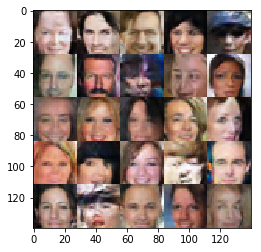

Epoch 10/10... Batch 220... Discriminator Loss: 1.3800... Generator Loss: 3.0445
Epoch 10/10... Batch 240... Discriminator Loss: 0.5655... Generator Loss: 2.0696
Epoch 10/10... Batch 260... Discriminator Loss: 0.8746... Generator Loss: 1.1575
Epoch 10/10... Batch 280... Discriminator Loss: 0.8807... Generator Loss: 1.0953
Epoch 10/10... Batch 300... Discriminator Loss: 1.0388... Generator Loss: 0.9337
Epoch 10/10... Batch 320... Discriminator Loss: 1.5003... Generator Loss: 0.5424
Epoch 10/10... Batch 340... Discriminator Loss: 1.2496... Generator Loss: 2.5867
Epoch 10/10... Batch 360... Discriminator Loss: 0.9484... Generator Loss: 0.9667
Epoch 10/10... Batch 380... Discriminator Loss: 0.8736... Generator Loss: 1.6786
Epoch 10/10... Batch 400... Discriminator Loss: 1.3419... Generator Loss: 0.5869


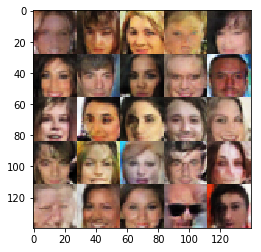

Epoch 10/10... Batch 420... Discriminator Loss: 0.6066... Generator Loss: 2.7696
Epoch 10/10... Batch 440... Discriminator Loss: 1.1637... Generator Loss: 0.7485
Epoch 10/10... Batch 460... Discriminator Loss: 0.7282... Generator Loss: 2.2386
Epoch 10/10... Batch 480... Discriminator Loss: 1.1610... Generator Loss: 3.0477
Epoch 10/10... Batch 500... Discriminator Loss: 1.7359... Generator Loss: 0.3717
Epoch 10/10... Batch 520... Discriminator Loss: 0.5226... Generator Loss: 2.1885
Epoch 10/10... Batch 540... Discriminator Loss: 0.6385... Generator Loss: 1.7095
Epoch 10/10... Batch 560... Discriminator Loss: 0.9928... Generator Loss: 3.4149
Epoch 10/10... Batch 580... Discriminator Loss: 0.6123... Generator Loss: 2.0708
Epoch 10/10... Batch 600... Discriminator Loss: 0.7124... Generator Loss: 1.4903


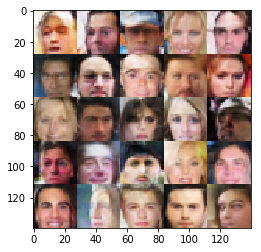

Epoch 10/10... Batch 620... Discriminator Loss: 1.2531... Generator Loss: 0.7121
Epoch 10/10... Batch 640... Discriminator Loss: 1.2687... Generator Loss: 0.7268
Epoch 10/10... Batch 660... Discriminator Loss: 1.6208... Generator Loss: 0.4665
Epoch 10/10... Batch 680... Discriminator Loss: 1.1085... Generator Loss: 0.7467
Epoch 10/10... Batch 700... Discriminator Loss: 0.7358... Generator Loss: 1.4971
Epoch 10/10... Batch 720... Discriminator Loss: 0.6830... Generator Loss: 1.4724
Epoch 10/10... Batch 740... Discriminator Loss: 1.3480... Generator Loss: 0.6677
Epoch 10/10... Batch 760... Discriminator Loss: 1.7232... Generator Loss: 3.3113
Epoch 10/10... Batch 780... Discriminator Loss: 0.6033... Generator Loss: 1.9276
Epoch 10/10... Batch 800... Discriminator Loss: 1.5392... Generator Loss: 0.5288


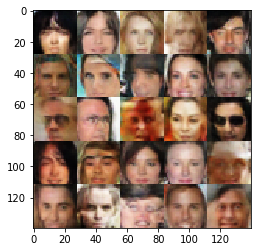

Epoch 10/10... Batch 820... Discriminator Loss: 0.5835... Generator Loss: 1.9823
Epoch 10/10... Batch 840... Discriminator Loss: 0.8594... Generator Loss: 2.6059
Epoch 10/10... Batch 860... Discriminator Loss: 0.9277... Generator Loss: 1.0973
Epoch 10/10... Batch 880... Discriminator Loss: 1.0962... Generator Loss: 0.8634
Epoch 10/10... Batch 900... Discriminator Loss: 0.4522... Generator Loss: 2.5665
Epoch 10/10... Batch 920... Discriminator Loss: 1.0242... Generator Loss: 0.8342
Epoch 10/10... Batch 940... Discriminator Loss: 1.7303... Generator Loss: 0.4353
Epoch 10/10... Batch 960... Discriminator Loss: 0.6578... Generator Loss: 1.5783
Epoch 10/10... Batch 980... Discriminator Loss: 1.5598... Generator Loss: 0.5499
Epoch 10/10... Batch 1000... Discriminator Loss: 0.4617... Generator Loss: 2.5556


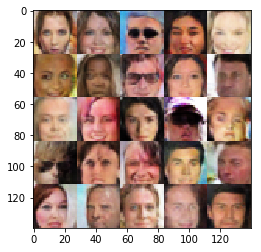

Epoch 10/10... Batch 1020... Discriminator Loss: 0.6889... Generator Loss: 1.7259
Epoch 10/10... Batch 1040... Discriminator Loss: 1.4909... Generator Loss: 0.5445
Epoch 10/10... Batch 1060... Discriminator Loss: 0.9933... Generator Loss: 0.9374
Epoch 10/10... Batch 1080... Discriminator Loss: 0.7311... Generator Loss: 1.6595
Epoch 10/10... Batch 1100... Discriminator Loss: 1.2811... Generator Loss: 0.7007
Epoch 10/10... Batch 1120... Discriminator Loss: 1.2812... Generator Loss: 0.7023
Epoch 10/10... Batch 1140... Discriminator Loss: 0.5754... Generator Loss: 1.9177
Epoch 10/10... Batch 1160... Discriminator Loss: 0.9185... Generator Loss: 2.3580
Epoch 10/10... Batch 1180... Discriminator Loss: 0.4679... Generator Loss: 2.4594
Epoch 10/10... Batch 1200... Discriminator Loss: 0.7957... Generator Loss: 1.2878


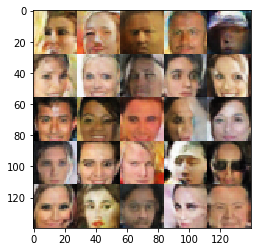

Epoch 10/10... Batch 1220... Discriminator Loss: 0.6014... Generator Loss: 1.9473
Epoch 10/10... Batch 1240... Discriminator Loss: 1.8976... Generator Loss: 0.3705
Epoch 10/10... Batch 1260... Discriminator Loss: 1.6854... Generator Loss: 2.7839
Epoch 10/10... Batch 1280... Discriminator Loss: 2.8908... Generator Loss: 4.0807
Epoch 10/10... Batch 1300... Discriminator Loss: 0.6183... Generator Loss: 1.6336
Epoch 10/10... Batch 1320... Discriminator Loss: 0.6989... Generator Loss: 1.4939
Epoch 10/10... Batch 1340... Discriminator Loss: 1.1660... Generator Loss: 0.7325
Epoch 10/10... Batch 1360... Discriminator Loss: 0.9034... Generator Loss: 1.0798
Epoch 10/10... Batch 1380... Discriminator Loss: 2.1018... Generator Loss: 3.6145
Epoch 10/10... Batch 1400... Discriminator Loss: 1.0408... Generator Loss: 0.8376


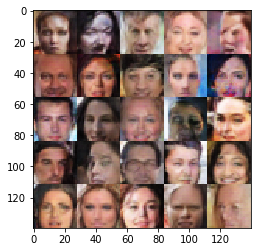

Epoch 10/10... Batch 1420... Discriminator Loss: 1.5286... Generator Loss: 2.6582
Epoch 10/10... Batch 1440... Discriminator Loss: 0.7645... Generator Loss: 1.2841
Epoch 10/10... Batch 1460... Discriminator Loss: 0.7937... Generator Loss: 1.3303
Epoch 10/10... Batch 1480... Discriminator Loss: 1.3260... Generator Loss: 0.5910
Epoch 10/10... Batch 1500... Discriminator Loss: 0.9964... Generator Loss: 0.9359
Epoch 10/10... Batch 1520... Discriminator Loss: 0.8395... Generator Loss: 1.1722
Epoch 10/10... Batch 1540... Discriminator Loss: 0.7105... Generator Loss: 1.6404
Epoch 10/10... Batch 1560... Discriminator Loss: 0.6310... Generator Loss: 2.9816
Epoch 10/10... Batch 1580... Discriminator Loss: 1.2344... Generator Loss: 0.7654


In [17]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Batch 20... Discriminator Loss: 0.7146... Generator Loss: 1.4529
Epoch 1/1... Batch 40... Discriminator Loss: 0.5076... Generator Loss: 2.2178
Epoch 1/1... Batch 60... Discriminator Loss: 1.8049... Generator Loss: 0.7050
Epoch 1/1... Batch 80... Discriminator Loss: 1.4295... Generator Loss: 0.7158
Epoch 1/1... Batch 100... Discriminator Loss: 0.9518... Generator Loss: 2.4652
Epoch 1/1... Batch 120... Discriminator Loss: 2.2118... Generator Loss: 0.2342
Epoch 1/1... Batch 140... Discriminator Loss: 1.6896... Generator Loss: 0.3701
Epoch 1/1... Batch 160... Discriminator Loss: 1.3668... Generator Loss: 1.4127
Epoch 1/1... Batch 180... Discriminator Loss: 1.4814... Generator Loss: 0.5319
Epoch 1/1... Batch 200... Discriminator Loss: 1.3951... Generator Loss: 0.6179


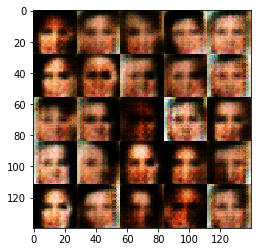

Epoch 1/1... Batch 220... Discriminator Loss: 1.0914... Generator Loss: 1.0574
Epoch 1/1... Batch 240... Discriminator Loss: 1.8660... Generator Loss: 3.4635
Epoch 1/1... Batch 260... Discriminator Loss: 0.9209... Generator Loss: 1.0288
Epoch 1/1... Batch 280... Discriminator Loss: 0.9830... Generator Loss: 0.9786
Epoch 1/1... Batch 300... Discriminator Loss: 1.0236... Generator Loss: 2.5013
Epoch 1/1... Batch 320... Discriminator Loss: 0.7184... Generator Loss: 1.6590
Epoch 1/1... Batch 340... Discriminator Loss: 1.5113... Generator Loss: 0.5558
Epoch 1/1... Batch 360... Discriminator Loss: 1.3650... Generator Loss: 0.5727
Epoch 1/1... Batch 380... Discriminator Loss: 1.0991... Generator Loss: 0.7800
Epoch 1/1... Batch 400... Discriminator Loss: 1.0135... Generator Loss: 1.3749


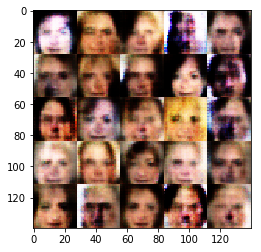

Epoch 1/1... Batch 420... Discriminator Loss: 0.9702... Generator Loss: 0.9278
Epoch 1/1... Batch 440... Discriminator Loss: 0.6926... Generator Loss: 1.6031
Epoch 1/1... Batch 460... Discriminator Loss: 1.9659... Generator Loss: 4.2726
Epoch 1/1... Batch 480... Discriminator Loss: 1.3110... Generator Loss: 0.5659
Epoch 1/1... Batch 500... Discriminator Loss: 1.0074... Generator Loss: 0.7919
Epoch 1/1... Batch 520... Discriminator Loss: 1.4940... Generator Loss: 0.4539
Epoch 1/1... Batch 540... Discriminator Loss: 1.3102... Generator Loss: 0.5490
Epoch 1/1... Batch 560... Discriminator Loss: 1.0291... Generator Loss: 0.8732
Epoch 1/1... Batch 580... Discriminator Loss: 1.1248... Generator Loss: 1.3766
Epoch 1/1... Batch 600... Discriminator Loss: 0.7411... Generator Loss: 1.5619


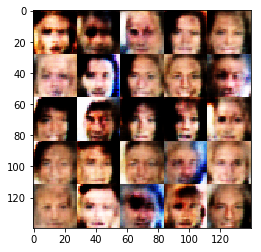

Epoch 1/1... Batch 620... Discriminator Loss: 1.1052... Generator Loss: 0.7945
Epoch 1/1... Batch 640... Discriminator Loss: 1.0039... Generator Loss: 1.0048
Epoch 1/1... Batch 660... Discriminator Loss: 1.0725... Generator Loss: 1.8585
Epoch 1/1... Batch 680... Discriminator Loss: 1.1556... Generator Loss: 0.8609
Epoch 1/1... Batch 700... Discriminator Loss: 0.9337... Generator Loss: 1.9651
Epoch 1/1... Batch 720... Discriminator Loss: 1.2037... Generator Loss: 2.3772
Epoch 1/1... Batch 740... Discriminator Loss: 1.1764... Generator Loss: 0.6435
Epoch 1/1... Batch 760... Discriminator Loss: 2.0229... Generator Loss: 2.3547
Epoch 1/1... Batch 780... Discriminator Loss: 0.6954... Generator Loss: 1.5632
Epoch 1/1... Batch 800... Discriminator Loss: 1.1252... Generator Loss: 0.7043


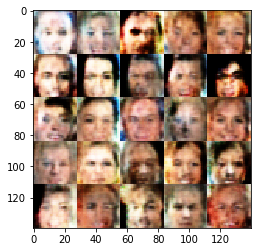

Epoch 1/1... Batch 820... Discriminator Loss: 0.8577... Generator Loss: 1.9107
Epoch 1/1... Batch 840... Discriminator Loss: 0.5948... Generator Loss: 1.6997
Epoch 1/1... Batch 860... Discriminator Loss: 1.3395... Generator Loss: 0.6299
Epoch 1/1... Batch 880... Discriminator Loss: 0.6890... Generator Loss: 1.9850
Epoch 1/1... Batch 900... Discriminator Loss: 0.7750... Generator Loss: 1.6742
Epoch 1/1... Batch 920... Discriminator Loss: 1.2013... Generator Loss: 0.6610
Epoch 1/1... Batch 940... Discriminator Loss: 0.8303... Generator Loss: 1.4646
Epoch 1/1... Batch 960... Discriminator Loss: 1.1880... Generator Loss: 1.8588
Epoch 1/1... Batch 980... Discriminator Loss: 1.3047... Generator Loss: 2.1424
Epoch 1/1... Batch 1000... Discriminator Loss: 0.7328... Generator Loss: 1.8990


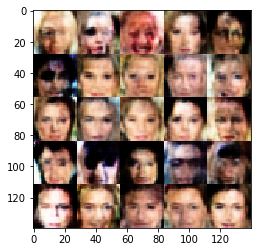

Epoch 1/1... Batch 1020... Discriminator Loss: 0.7934... Generator Loss: 1.4574
Epoch 1/1... Batch 1040... Discriminator Loss: 1.3931... Generator Loss: 2.4682
Epoch 1/1... Batch 1060... Discriminator Loss: 0.8386... Generator Loss: 1.6559
Epoch 1/1... Batch 1080... Discriminator Loss: 0.5560... Generator Loss: 2.0028
Epoch 1/1... Batch 1100... Discriminator Loss: 0.9174... Generator Loss: 1.9613
Epoch 1/1... Batch 1120... Discriminator Loss: 0.8147... Generator Loss: 1.7339
Epoch 1/1... Batch 1140... Discriminator Loss: 0.6798... Generator Loss: 1.6798
Epoch 1/1... Batch 1160... Discriminator Loss: 1.1246... Generator Loss: 2.2693
Epoch 1/1... Batch 1180... Discriminator Loss: 0.5444... Generator Loss: 2.0035
Epoch 1/1... Batch 1200... Discriminator Loss: 0.5650... Generator Loss: 2.3711


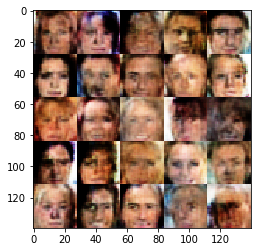

Epoch 1/1... Batch 1220... Discriminator Loss: 0.5176... Generator Loss: 2.6250
Epoch 1/1... Batch 1240... Discriminator Loss: 3.8685... Generator Loss: 4.8825
Epoch 1/1... Batch 1260... Discriminator Loss: 1.6705... Generator Loss: 3.1779
Epoch 1/1... Batch 1280... Discriminator Loss: 0.5523... Generator Loss: 3.1044
Epoch 1/1... Batch 1300... Discriminator Loss: 2.8486... Generator Loss: 3.7275
Epoch 1/1... Batch 1320... Discriminator Loss: 0.9779... Generator Loss: 1.8816
Epoch 1/1... Batch 1340... Discriminator Loss: 2.0896... Generator Loss: 3.2655
Epoch 1/1... Batch 1360... Discriminator Loss: 0.8331... Generator Loss: 1.1452
Epoch 1/1... Batch 1380... Discriminator Loss: 0.5898... Generator Loss: 2.9657
Epoch 1/1... Batch 1400... Discriminator Loss: 0.8034... Generator Loss: 1.4378


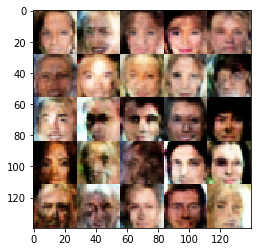

Epoch 1/1... Batch 1420... Discriminator Loss: 0.7645... Generator Loss: 2.5669
Epoch 1/1... Batch 1440... Discriminator Loss: 0.4662... Generator Loss: 2.8285
Epoch 1/1... Batch 1460... Discriminator Loss: 0.4830... Generator Loss: 2.2267
Epoch 1/1... Batch 1480... Discriminator Loss: 1.1880... Generator Loss: 2.5878
Epoch 1/1... Batch 1500... Discriminator Loss: 2.5744... Generator Loss: 3.0812
Epoch 1/1... Batch 1520... Discriminator Loss: 1.3661... Generator Loss: 1.8214
Epoch 1/1... Batch 1540... Discriminator Loss: 1.6152... Generator Loss: 0.3727
Epoch 1/1... Batch 1560... Discriminator Loss: 0.8058... Generator Loss: 2.8476
Epoch 1/1... Batch 1580... Discriminator Loss: 1.2073... Generator Loss: 0.9252


In [20]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    dis, gen, f1 = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [23]:
import matplotlib.pyplot as plt

plt.plot(dis)
plt.show()
plt.plot(gen)
plt.show()
plt.plot(f1)
plt.show()

In [37]:
idx = f1.index(min(f1))
print(dis[idx], gen[idx])

1.0559595 0.7370529


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.